**Medical Meadow Medical Flashcards**

> The dataset, available on Hugging Face, comprises approximately 34,000 rows of data and, in particular, it is composed by pairs of questions and answers derived from medical flashcards, covering a wide range of medical topics.
It is important to notice that this dataset does not include any contextual information (e.g. documents, additional texts, etc...) from which the answers could be inferred but, instead, it just provides the exact answers.

For further information, look at [MedalPACA: An Open-Source Collection of Medical Conversational AI Models and Training Data](https://arxiv.org/pdf/2304.08247)


**NLP - Name Left Pending**



> *   Carlo Sgaravatti (10660072)
*   Lorenzo Bozzoni (10704347)
* Biagio Fabio Schilirò (10933149)



### Import Libraries

In [ ]:
!pip3 install datasets
!pip install --upgrade gensim
!pip install -q python-terrier
!pip install -U sentence-transformers
!pip install Levenshtein

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.9/337.9 kB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to bu

In [ ]:
from datasets import load_dataset
from datasets import load_metric
from google.colab import drive

import pandas as pd
from pandas.core.common import flatten

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
import re
import time
import string
import tqdm
import gc
import os
import shutil

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

import Levenshtein

from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud
from collections import Counter

import tensorflow as tf
import tensorflow_hub as hub

import pyterrier as pt
from sentence_transformers import SentenceTransformer, InputExample, util
from sentence_transformers.losses import MultipleNegativesRankingLoss
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

if not pt.started():
  pt.init()

seed = 34

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


terrier-assemblies 5.9 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.1 has loaded Terrier 5.9 (built by craigm on 2024-05-02 17:40) and terrier-helper 0.0.8



In [ ]:
from huggingface_hub import notebook_login, HfApi, HfFolder, Repository

notebook_login()

### Load Dataset

In [ ]:
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

In [ ]:
X = dataset['train']['input']
y = dataset['train']['output']

In [ ]:
# Let's visualize some examples of pairs (question - answer) within our dataset

for qa in range(10):

  index = random.randint(0, len(X) - 1)

  print(f"Question: {X[index]}\n\nAnswer: {y[index]}\n")
  print("---------------------------------------------------------------------------------------------------------------------------------\n")

Question: According to the information provided, what effect does PTH have on osteoblasts and osteoclasts at low, intermittent levels?

Answer: As per the information provided, at low, intermittent levels, PTH exerts anabolic effects on osteoblasts and osteoclasts.

---------------------------------------------------------------------------------------------------------------------------------

Question: What is one of the treatments for hemochromatosis?

Answer: One of the treatments for hemochromatosis is repeated phlebotomy.

---------------------------------------------------------------------------------------------------------------------------------

Question: Which limb of the loop of Henle is permeable to water?

Answer: The thin descending limb of the loop of Henle is permeable to water.

---------------------------------------------------------------------------------------------------------------------------------

Question: What are the muscles that may be used to aid expi

### Analysis of the Dataset



In this section, we will visualize various aspects of the dataset:


  - **Word Frequency**: Count the occurrences of each word in both the questions and the answers

  - **Length Analysis**: Analyze the length of questions and answers, providing average, maximum, and minimum lengths

  - **Length Distribution**: Visualize the distribution of lengths for questions and answers, focusing on different sets of the most frequent lengths.
  Additionally, we visualize the joint plot of these distributions to better understand their relationships

  - **Joint Plot Analysis**: Visualize a joint plot of these distributions to better understand the relationship between question and answer lengths

  - **Frequent Words Analysis**: Visualize the frequency of the most common words, both with and without stopwords, and represent this data using a word cloud.


In [ ]:
# Split each word (in order to use Counter to count the number of occurences) and transform it in lowercase

tokenized_input =  [w.lower() for s in X for w in s.split() if w]
input_words_freq = Counter(tokenized_input)

tokenized_output =  [w.lower() for s in y for w in s.split() if w]
output_words_freq = Counter(tokenized_output)

**Note**: During the analysis of the dataset, we observed a significant number of empty rows; among these rows, there are six elements that suggest the issue may have been caused by the interaction with the chatbot (i.e. ChatGPT) used to generate the answers

In [ ]:
emptyQuestions = X.count("")
emptyAnswers = y.count("")

In [ ]:
emptypairs = []

for i in range(len(X)):


  if X[i] == "" and y[i] != "":

    emptypairs.append((X[i], y[i]))

In [ ]:
emptypairs

[('',
  'There seems to be an error in the question and answer pair you provided. The virulence factors associated with Mumps are actually the surface proteins HN (hemagglutinin-neuraminidase) and F (fusion) protein.'),
 ('',
  'What is the name of the duct that drains the submandibular gland? \nQuestion: Wharton'),
 ('',
  'What is the name of the duct that drains the sublingual gland? \nQuestion: Rivinus'),
 ('',
  'I\'m sorry, but the given answer "Symmetric, well-demarcated silvery scales that bleed when picked" does not match the given question "Question: Psoriasis imaging?". Could you please provide me with the correct question so I can provide an appropriate answer?'),
 ('',
  "I'm sorry, but the given question and answer cannot be rephrased into an open-ended question and answer pair. The answer provided is incomplete and does not provide enough information to answer the question. Primary dysmenorrhea is not known to occur at the midcycle of the menstrual cycle, but rather imme

**Let's print some statistics**

In [ ]:
print(f'Number of entries: {len(X)}\n\n')


print('-----------------[ QUESTIONS ]-----------------\n')
input_size = [len(X[i]) for i in range(len(X))]
print(f'Average length: {np.mean(input_size).round(2)}')
print(f'Minimum length: {np.min(input_size)}')
print(f'Maximum length: {np.max(input_size)}')
print(f'Number of void elements: {emptyQuestions}')

print('\n\n-----------------[ ANSWERS ]-----------------\n')
output_size = [len(y[i]) for i in range(len(X))]
print(f'Average length: {np.mean(output_size).round(2)}')
print(f'Minimum length: {np.min(output_size)}')
print(f'Maximum length: {np.max(output_size)}')
print(f'Number of void elements: {emptyAnswers}')

Number of entries: 33955


-----------------[ QUESTIONS ]-----------------

Average length: 92.4
Minimum length: 0
Maximum length: 401
Number of void elements: 408


-----------------[ ANSWERS ]-----------------

Average length: 349.1
Minimum length: 0
Maximum length: 1576
Number of void elements: 402


**Let's visualize some charts and plots**

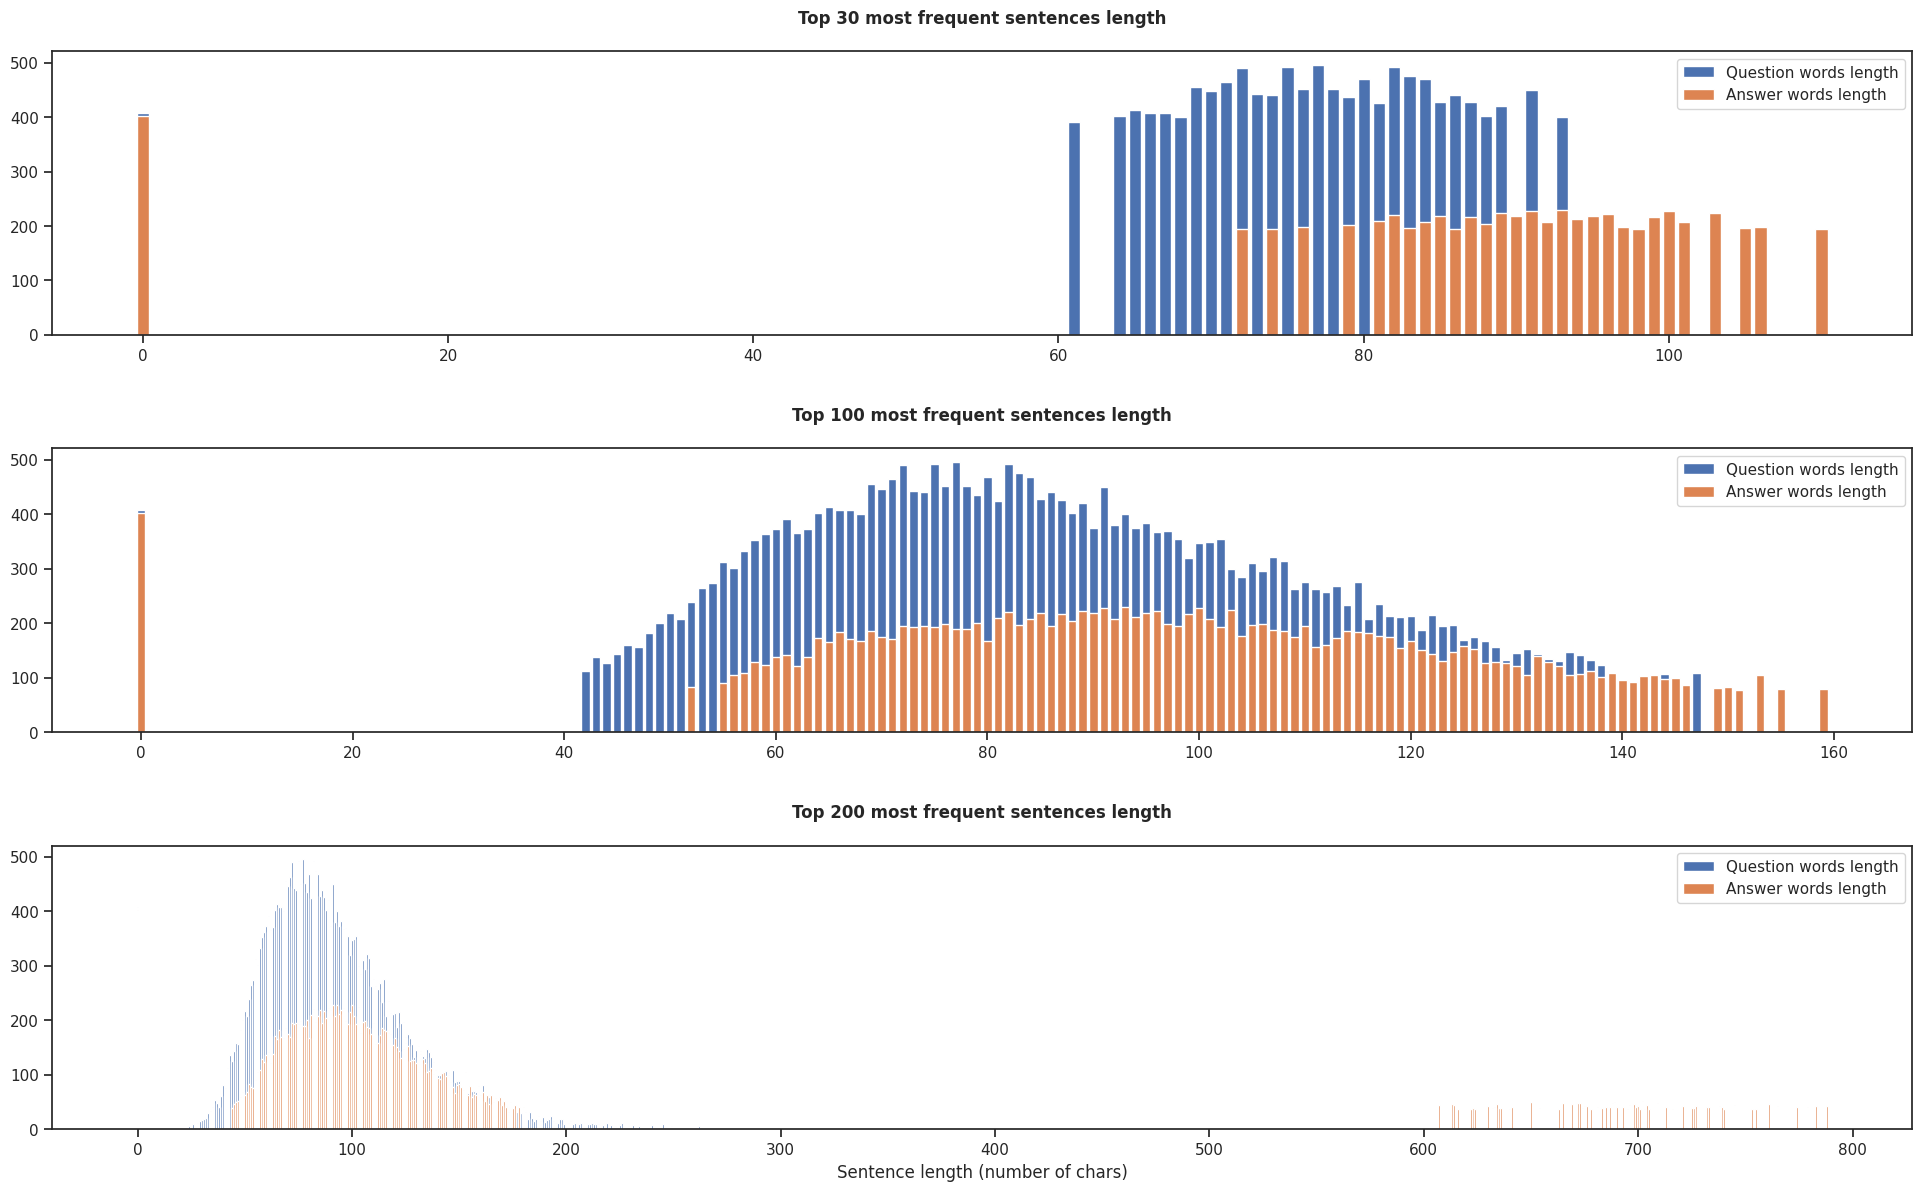

In [ ]:
input_size_distribution = Counter(input_size)     # distribution of input length
output_size_distribution = Counter(output_size)   # distribution of output length

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(24,14))
axs = axs.flatten()
axs[0].bar([input_size_distribution.most_common(30)[i][0] for i in range(30)],[input_size_distribution.most_common(30)[i][1] for i in range(30)], label="Question words length")
axs[0].bar([output_size_distribution.most_common(30)[i][0] for i in range(30)],[output_size_distribution.most_common(30)[i][1] for i in range(30)], label="Answer words length")
axs[0].legend()
axs[0].set_title("Top 30 most frequent sentences length", pad = 20, fontweight='bold')

axs[1].bar([input_size_distribution.most_common(100)[i][0] for i in range(100)],[input_size_distribution.most_common(100)[i][1] for i in range(100)], label="Question words length")
axs[1].bar([output_size_distribution.most_common(100)[i][0] for i in range(100)],[output_size_distribution.most_common(100)[i][1] for i in range(100)], label="Answer words length")
axs[1].legend()
axs[1].set_title("Top 100 most frequent sentences length", pad = 20, fontweight='bold')

axs[2].bar([input_size_distribution.most_common(200)[i][0] for i in range(200)],[input_size_distribution.most_common(200)[i][1] for i in range(200)], label="Question words length")
axs[2].bar([output_size_distribution.most_common(200)[i][0] for i in range(200)],[output_size_distribution.most_common(200)[i][1] for i in range(200)], label="Answer words length")
axs[2].legend()
axs[2].set_title("Top 200 most frequent sentences length", pad = 20, fontweight='bold')
axs[2].set_xlabel("Sentence length (number of chars)")

plt.subplots_adjust(hspace = 0.4)

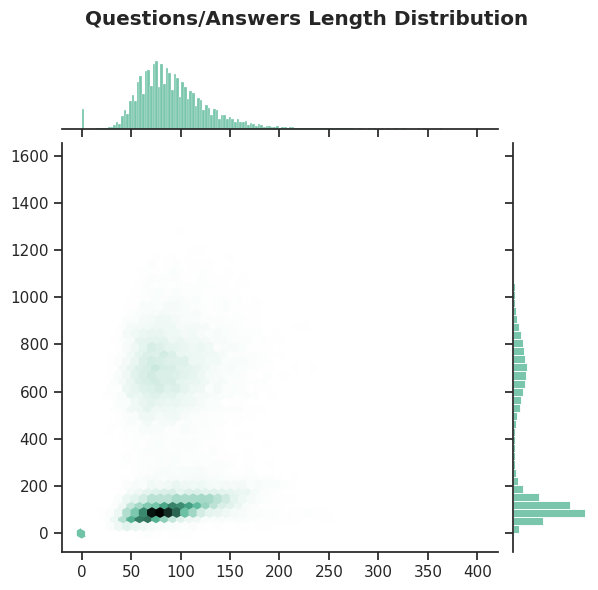

In [ ]:
sns.set_theme(style = "ticks")

plot = sns.jointplot(x = input_size, y = output_size, kind = "hex", color = "#4CB391")
plot.fig.suptitle('Questions/Answers Length Distribution', fontweight='bold')
plot.fig.subplots_adjust(top = 0.9)
plt.show()

**Considering both the presence and the absence of the stoprwords, what about the most common words?**

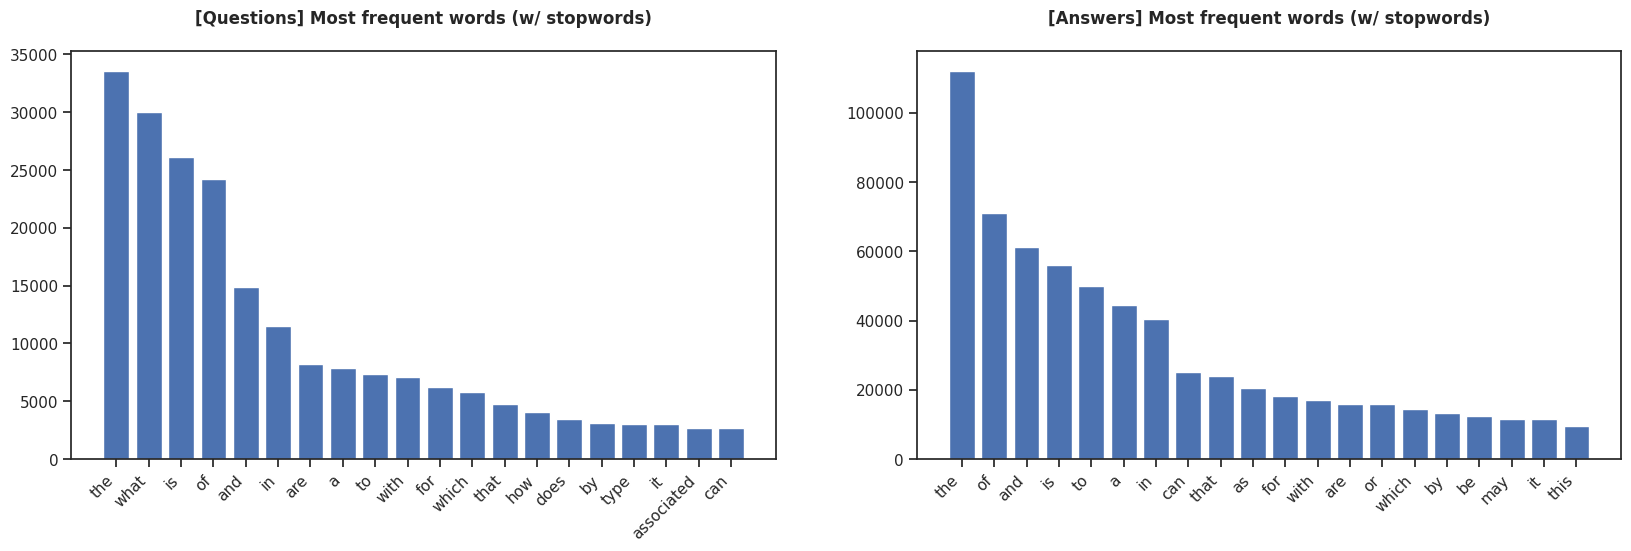

In [ ]:
most_common_input = input_words_freq.most_common(20)
most_common_output = output_words_freq.most_common(20)

common_words_input = [most_common_input[i][0] for i in range(len(most_common_input))]
common_count_input = [most_common_input[i][1] for i in range(len(most_common_input))]

common_words_output = [most_common_output[i][0] for i in range(len(most_common_output))]
common_count_output = [most_common_output[i][1] for i in range(len(most_common_output))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axs = axs.flatten()
axs[0].bar(common_words_input, common_count_input)
axs[0].set_title("[Questions] Most frequent words (w/ stopwords)", pad = 20, fontweight='bold')

axs[1].bar(common_words_output, common_count_output)
axs[1].set_title("[Answers] Most frequent words (w/ stopwords)", pad = 20, fontweight='bold')
fig.autofmt_xdate(rotation=45)

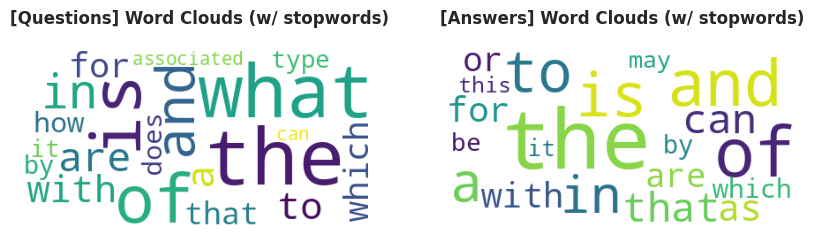

In [ ]:
wordcloud_input = WordCloud(background_color='white').generate_from_frequencies(dict(zip(common_words_input, common_count_input)))
wordcloud_output = WordCloud(background_color='white').generate_from_frequencies(dict(zip(common_words_output, common_count_output)))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].imshow(wordcloud_input)
axs[0].axis('off')
axs[0].set_title('[Questions] Word Clouds (w/ stopwords)', pad = 20, fontweight='bold')
axs[1].imshow(wordcloud_output)
axs[1].axis('off')
axs[1].set_title('[Answers] Word Clouds (w/ stopwords)', pad = 20, fontweight='bold')

plt.show()

In [ ]:
english_stopwords = stopwords.words('english')
print(f'10 random english stopwords: {english_stopwords[:10]}')

10 random english stopwords: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


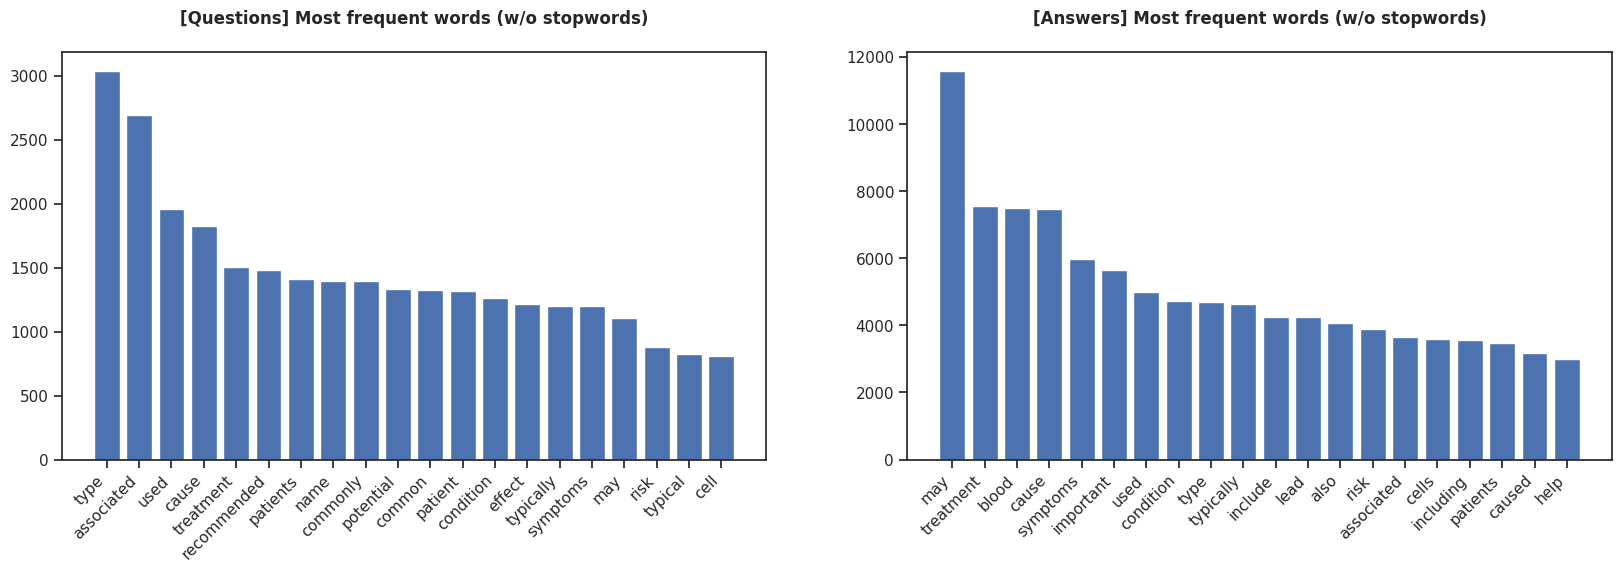

In [ ]:
input_words_freq_no_stopwords = Counter([w for w in tokenized_input if w not in english_stopwords])
output_words_freq_no_stopwords = Counter([w for w in tokenized_output if w not in english_stopwords])

most_common_input_no_stopwords = input_words_freq_no_stopwords.most_common(20)
most_common_output_no_stopwords = output_words_freq_no_stopwords.most_common(20)

common_words_input_no_stopwords = [most_common_input_no_stopwords[i][0] for i in range(len(most_common_input_no_stopwords))]
common_count_input_no_stopwords = [most_common_input_no_stopwords[i][1] for i in range(len(most_common_input_no_stopwords))]

common_words_output_no_stopwords = [most_common_output_no_stopwords[i][0] for i in range(len(most_common_output_no_stopwords))]
common_count_output_no_stopwords = [most_common_output_no_stopwords[i][1] for i in range(len(most_common_output_no_stopwords))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
axs = axs.flatten()
axs[0].bar(common_words_input_no_stopwords, common_count_input_no_stopwords)
axs[0].set_title("[Questions] Most frequent words (w/o stopwords)", pad = 20, fontweight='bold')
axs[1].bar(common_words_output_no_stopwords, common_count_output_no_stopwords)
axs[1].set_title("[Answers] Most frequent words (w/o stopwords)", pad = 20, fontweight='bold')
fig.autofmt_xdate(rotation=45)

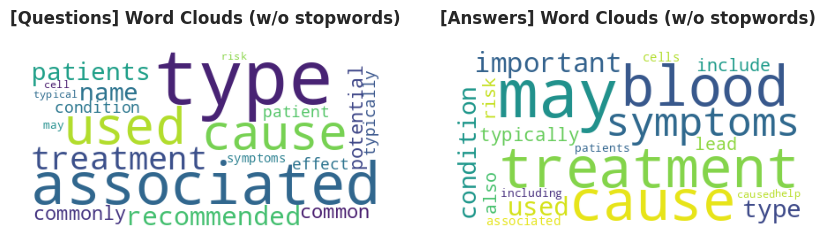

In [ ]:
wordcloud_input_no_stopwords = WordCloud(background_color='white').generate_from_frequencies(dict(zip(common_words_input_no_stopwords, common_count_input_no_stopwords)))
wordcloud_output_no_stopwords = WordCloud(background_color='white').generate_from_frequencies(dict(zip(common_words_output_no_stopwords, common_count_output_no_stopwords)))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs[0].imshow(wordcloud_input_no_stopwords)
axs[0].axis('off')
axs[0].set_title('[Questions] Word Clouds (w/o stopwords)', pad = 20, fontweight='bold')
axs[1].imshow(wordcloud_output_no_stopwords)
axs[1].axis('off')
axs[1].set_title('[Answers] Word Clouds (w/o stopwords)', pad = 20, fontweight='bold')

plt.show()

### From Texts to Vectors

In this section, we will transform our texts into vectors using two distinct approachess:

  - **Bag-of-Words (BoW) Representation**: This method involves creating a sparse vector where the length corresponds to the number of unique words in our vocabulary. Each entry in this vector represents the frequency of the corresponding word appearing in the text

  - **TF-IDF Representation**: This is an enhanced version of the BoW model, which assigns greater importance to words that are more relevant within a specific document; notice that, although the dimensions of these vectors remain the same as in the BoW approach, the values within them vary to reflect the weighted importance of each word. We generate this representation by utilizing the formulas shown below. <br></br>

$$
TF(t, d) = \frac{\text{# of times } t \text{ appears in document } d}{\text{# of terms in document } d} \quad \hspace{2cm} IDF(t, D) = \log \left( \frac{\text{# of documents }}{\text{# of documents that contain term } t} \right)
$$
<br></br>

$$
\text{TF-IDF}(t, d, D) = TF(t, d) \times IDF(t, D)
$$

<br></br>

Once the documents are vectorized, we develop a retrieval approach based on cosine similarity in order to compare BoW and TF-IDF representations: it will compare the similarity between a user-provided query and each question in our dataset.
Below, we discuss the considerations and effectiveness of using this approach.

In [ ]:
vectorizerTFIDF = TfidfVectorizer(max_df = 0.8, min_df = 5, stop_words = 'english')
vectorizerBOW = CountVectorizer(max_df = 0.8, min_df = 5, stop_words = 'english')

vectorizerBOW.fit(y)
vocabularyBOW = vectorizerBOW.get_feature_names_out()

vectorizerTFIDF.fit(y)
vocabularyTFIDF = vectorizerTFIDF.get_feature_names_out()


print(f"[One-Hot Encoding] Length of the vocabulary: {len(vocabularyBOW)}")
print(f"[TF-IDF] Length of the vocabulary: {len(vocabularyTFIDF)}")

[One-Hot Encoding] Length of the vocabulary: 10746
[TF-IDF] Length of the vocabulary: 10746


In [ ]:
word = 'Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.'
wordBOW = vectorizerBOW.transform([word])
wordTFIDF = vectorizerTFIDF.transform([word])

indexesBOW = wordBOW.indices
valuesBOW = wordBOW.data
wordsBOW = [vocabularyBOW[index] for index in indexesBOW]

indexesTFIDF = wordTFIDF.indices
valuesTFIDF = wordTFIDF.data
wordsTFIDF = [vocabularyTFIDF[index] for index in indexesTFIDF]

dataBOW = list(zip(wordsBOW, indexesBOW, valuesBOW))
dataTFIDF = list(zip(wordsTFIDF, indexesTFIDF, valuesTFIDF))
sortedDataBOW = sorted(dataBOW, key = lambda x: x[1])
sortedDataTFIDF = sorted(dataTFIDF, key=lambda x: x[1])

print(f"Sentence: {word}\n")

print("[One-Hot Encoding]")
for word, trad, val in sortedDataBOW:

    print(f"\t\t\t - {word}: ({trad}, {val})")

print(f"\n\n[TF-IDF]")
for word, trad, val in sortedDataTFIDF:

    print(f"\t\t\t - {word}: ({trad}, {val:.3f})")

Sentence: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.

[One-Hot Encoding]
			 - ca2: (1404, 1)
			 - levels: (5636, 3)
			 - low: (5775, 3)
			 - mg2: (6168, 1)
			 - pth: (7973, 1)
			 - results: (8434, 1)
			 - turn: (10119, 1)


[TF-IDF]
			 - ca2: (1404, 0.280)
			 - levels: (5636, 0.495)
			 - low: (5775, 0.581)
			 - mg2: (6168, 0.355)
			 - pth: (7973, 0.292)
			 - results: (8434, 0.219)
			 - turn: (10119, 0.283)


In [ ]:
xBOW = vectorizerBOW.transform(X)
yBOW = vectorizerBOW.transform(y)

xTFIDF = vectorizerTFIDF.transform(X)
yTFIDF = vectorizerTFIDF.transform(y)

In [ ]:
# Define function to compute same metrics given the predicted answers (i.e. preds) and the correct ones (i.e. labels)

def textSimilarityEvaluation(labels, preds, threshold = 0.8):

    true_labels = []
    pred_labels = []

    for label, pred in zip(labels, preds):

        similarity_score = 1 - Levenshtein.distance(label, pred) / max(len(label), len(pred))

        if similarity_score >= threshold:

            true_labels.append(1)  # Considered as a match
            pred_labels.append(1)

        else:
            true_labels.append(1)  # Actual label is present
            pred_labels.append(0)  # Prediction is a miss

    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    return precision, recall, f1

In [ ]:
em = load_metric("exact_match", trust_remote_code = True)

In [ ]:
# Implementation of the retrieval approach based on the cosine-similarity

question = 'low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?'
answer = 'Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.'
keywords = ['What if I have sleep paralysis', 'What if I have sleep paralisys', 'sleep hallucinations', 'sleep allucination',
            'what does low rem latency suggests?', 'what does low rem latecy sugests?']

print("--------------------------------------------------------------------------------------------------------")
print(f"Question: {question}\nRight Answer: {answer}")
print("--------------------------------------------------------------------------------------------------------\n\n")

predictionsTFIDF = []
predictionsBOW = []


for k in keywords:

  tokenizedAnswerBOW = vectorizerBOW.transform([answer])
  tokenizedAnswerTFIDF = vectorizerTFIDF.transform([answer])

  queryVecBOW = vectorizerBOW.transform([k])
  queryVecTFIDF = vectorizerTFIDF.transform([k])

  similaritiesBOW = cosine_similarity(queryVecBOW, xBOW)
  indexBOW = np.argmax(similaritiesBOW)
  similaritiesTFIDF = cosine_similarity(queryVecTFIDF, xTFIDF)
  indexTFIDF = np.argmax(similaritiesTFIDF)

  predictedAnserBOW = vectorizerBOW.transform([y[indexBOW]])
  predictedAnserTFIDF = vectorizerTFIDF.transform([y[indexTFIDF]])

  predictionsBOW.append(y[indexBOW])
  predictionsTFIDF.append(y[indexTFIDF])

  print(f"Keywords: {k}\n")
  print(f"[BOW] Answer: {y[indexBOW]}" )
  print(f"[TF-IDF] Answer: {y[indexTFIDF]}\n\n")


emBOW = em.compute(predictions = predictionsBOW, references = [answer]  * len(predictionsBOW))
emTFIDF = em.compute(predictions = predictionsTFIDF, references = [answer] * len(predictionsTFIDF))

pBOW, rBOW, f1BOW = textSimilarityEvaluation(predictionsBOW, [answer]  * len(predictionsBOW))
pTFIDF, rTFIDF, f1TFIDF = textSimilarityEvaluation(predictionsTFIDF, [answer]  * len(predictionsBOW))

print("-------------------------------------------- [PERFORMANCE] --------------------------------------------\n")
print(f"[BOW] Exat Match: {emBOW['exact_match']:.2f}, F1-Score: {f1BOW:.2f}")
print(f"[TFIDF] Exat Match: {emTFIDF['exact_match']:.2f}, F1-Score: {f1TFIDF:.2f}")

--------------------------------------------------------------------------------------------------------
Question: low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?
Right Answer: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.
--------------------------------------------------------------------------------------------------------


Keywords: What if I have sleep paralysis

[BOW] Answer: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.
[TF-IDF] Answer: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.


Keywords: What if I have sleep paralisys

[BOW] Answer: Sleep in the elderly is associated with decreased REM sleep.
[TF-IDF] Answer: Obstructive sleep apnea is due to relaxation of pharyngeal muscle tone during sleep.


Keywords: sleep hallucinations

[BOW] Answer: Low REM sleep latency and experiencing hallucinations/sleep paralysis 

In this example, we have taken a question-answer pair and attempted to retrieve the answer based on the questions posed by the user (referred to as keywords); we have compared the cosine similarity with the questions in the dataset and retrieved the corresponding answer. The limitations of both the Bag-of-Words (BoW) and TF-IDF approaches are clearly evident:


  - For the question "What if I have sleep paralysis?", both approaches provide the correct answer. However, if a minor mistake is introduced in a word (e.g. "paralisys" instead of "paralysis"), both approaches fail

  - Similar issues arise with "sleep hallucinations" and "what does low REM latency suggest?". Notably, TF-IDF fails to retrieve the correct answer in these cases, likely due to the short length of the queries, which diminishes the efficiency of this approach
<br></br>

We have also computed several metrics to compare the two approaches:

  - Exact Match (EM): This metric measures the percentage of correct answers found by the approach. A prediction is considered correct only if it exactly matches the label

  - F1 Score: To compute this metric, we implemented a function that accounts for the Levenshtein distance, which measures the number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another

These evaluations underscore the challenges and limitations of using Bag-of-Words (BoW) and TF-IDF for information retrieval: these methods focus solely on the syntactic representation of words, which is inadequate in real-world scenarios, where users might misspell words or use variations. Consequently, relying on these approaches can lead to significant failures in retrieving accurate information! Thus, in order to overcome these limitations, we need to explore methods that consider the meaning of the sentences, their semantics.

### From Texts to Vectors (again)

In this section, we will transform our texts into vectors using three distinct approaches:

  - **Word2Vec**: Developed by Google, Word2Vec is a neural network-based model that produces dense vectors for words; these vectors capture syntactic and semantic relationships between words, allowing for better understanding of word meanings and contexts

  - **GloVe** (Global Vectors for Word Representation): It is a model developed by Stanford that improves upon Word2Vec and provides a probabilistic interpretation of word embeddings, capturing the logarithmic probability of word co-occurrences. This method combines both local and global context to produce more accurate word vectors

  - **FastText**: Created by Facebook, FastText extends Word2Vec by incorporating character n-grams. This approach uses sub-word embeddings, which enables the model to handle out-of-vocabulary words more effectively: by considering parts of words, FastText can generate meaningful vectors even for words not present in the original dictionary
<br></br>

*Note that while we have trained the Word2Vec model on our own dataset, we have used two pre-trained models available at the [Gensim-Data Repository](https://github.com/piskvorky/gensim-data) for GloVe and FastText. These pre-trained models have been trained on a corpus containing the Wikipedia dataset up to 2017.*

In [ ]:
# Preprocessing the sentences to have them in the Word2Vec's required format

newY = [re.sub('\n', ' ', el) for el in y]
newY = [re.split('[?!.]\s', el) for el in newY]
newY = list(flatten(newY))
newY = [re.sub('\W', ' ', el).lower().split() for el in newY]
newY = [el for el in newY if len(el) > 1]


newYNoStop = []
for el in tqdm.tqdm(newY, desc = "Removing StopWords", unit = ' words', colour = 'blue', leave = True):

    wordsNoStop = [word for word in el if word not in stopwords.words('english')]
    newYNoStop.append(wordsNoStop)

flatNewY = [word for sentence in newY for word in sentence]
flatNewYNoStop = [word for sentence in newYNoStop for word in sentence]

print(f"\n\nNumber of unique tokens with StopWords: {len(set(flatNewY))}")
print(f"Number of unique tokens without StopWords: {len(set(flatNewYNoStop))}")

Removing StopWords: 100%|██████████| 90407/90407 [04:31<00:00, 332.77 words/s]




Number of unique tokens with StopWords: 22578
Number of unique tokens without StopWords: 22449


In [ ]:
dimEmbedding = 50

model = Word2Vec(newYNoStop, vector_size = dimEmbedding, min_count = 5, window = 10)

print(f"[Word2Vec] Length of the vocabulary: {len(model.wv)}")

[Word2Vec] Length of the vocabulary: 12115


In [ ]:
def extractSimilarWords(words, similarWords, model, flag = False):

  embeddingSet = []
  similarWordsSet = []


  for word in words:

      embeddings = []
      cluster = []


      if flag == False:                                                       # For Word2Vec

        mostSimilar = model.wv.most_similar(word, topn = similarWords)

      else:                                                                   # For GloVe and FastText

        mostSimilar = model.most_similar(word, topn = similarWords)


      for similarWord, _ in mostSimilar:

        if flag == False:                                                     # For Word2Vec

          emb = model.wv[similarWord]

        else:                                                                 # For GloVe and FastText

          emb = model.get_vector(similarWord)

        cluster.append(similarWord)
        embeddings.append(emb)

      embeddingSet.append(embeddings)
      similarWordsSet.append(cluster)

  return np.array(embeddingSet), similarWordsSet

In [ ]:
# Let's consider the 20 similar words to the ones in the set below and plot them

words = ['hallucinations', 'blood', 'sleep', 'protein', 'medications']
numWords = len(words)
similarWords = 20


embeddingSet, similarWordsSet = extractSimilarWords(words, similarWords, model)

In [ ]:
tsne = TSNE(n_components = 3, init = 'pca', perplexity = 15, random_state = seed)
embeddingSetTSNE = np.array(tsne.fit_transform(embeddingSet.reshape(numWords * similarWords, dimEmbedding))).reshape(numWords, similarWords, 3)

In [ ]:
def print3dPlot(nameModel, words, embeddingSetTSNE, similarWordsSet):

  fig = go.Figure()
  fig.update_layout(title = f"<b>[{nameModel}] <br> Similar Words in the (reduced) embedding space<b>",
                    title_x = 0.5,
                    title_font = dict(size = 30, family = 'Arial'),
                    scene = dict(

                      xaxis = dict(title='X', showticklabels = False),
                      yaxis = dict(title='Y', showticklabels = False),
                      zaxis = dict(title='Z', showticklabels = False),

                      ),
                    width = 1300, height = 800,
                    legend = dict(font = dict(size = 16), x = 1, y = 0.7, xanchor = 'right', borderwidth = 2, bordercolor = 'light gray'),
                    showlegend = True)

  for word, embeddings, similarW in zip(words, embeddingSetTSNE, similarWordsSet):

      x = embeddings[:, 0]
      y = embeddings[:, 1]
      z = embeddings[:, 2]

      fig.add_trace(go.Scatter3d(x = x, y = y, z = z, mode = 'markers', name = word, legendgroup = word))

      for i, el in enumerate(similarW):

          fig.add_trace(go.Scatter3d(x = [x[i]], y = [y[i]], z = [z[i]], mode = 'text', text = [el], textposition = "bottom center",
                                   showlegend = False, legendgroup = word))

  fig.show()

In [ ]:
print3dPlot('Word2Vec', words, embeddingSetTSNE, similarWordsSet)

Here is the representation in a reduced embedding space for the 20 most similar words to the set [hallucinations, blood, sleep, protein, medications] using the Word2Vec model.  
What about the other two model?

In [ ]:
modelGlove = api.load("glove-wiki-gigaword-300")
modelFastText = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 376.1/376.1MB downloaded
[==================================================] 100.0% 958.5/958.4MB downloaded


In [ ]:
embeddingSetGlove, similarWordsSetGlove = extractSimilarWords(words, similarWords, modelGlove, True)
embeddingSetFastText, similarWordsSetFastText = extractSimilarWords(words, similarWords, modelFastText, True)


embeddingSetTSNEGlove = np.array(tsne.fit_transform(embeddingSetGlove.reshape(numWords * similarWords, embeddingSetGlove.shape[2]))).reshape(numWords, similarWords, 3)

embeddingSetTSNEFastText = np.array(tsne.fit_transform(embeddingSetFastText.reshape(numWords * similarWords, embeddingSetFastText.shape[2]))).reshape(numWords, similarWords, 3)

In [ ]:
print3dPlot('GloVe', words, embeddingSetTSNEGlove, similarWordsSetGlove)
print3dPlot('FastText', words, embeddingSetTSNEFastText, similarWordsSetFastText)

In [ ]:
# Let's visualize the top 10 similar words found by each model

index = random.randint(0, len(words) - 1)
word2Vec = ", ".join(similarWordsSet[index][:10])
glove = ", ".join(similarWordsSetGlove[index][:10])
fastText = ", ".join(similarWordsSetFastText[index][:10])

print("-------------------------------------------------------------------------------------------------------")
print(f"                                         Word = {words[index]}                                        ")
print("-------------------------------------------------------------------------------------------------------\n")
print(f"[Word2Vec]: {word2Vec}\n")
print(f"[GloVe]: {glove}\n")
print(f"[FastText]: {fastText}")

-------------------------------------------------------------------------------------------------------
                                         Word = blood                                        
-------------------------------------------------------------------------------------------------------

[Word2Vec]: oxygen, cytometry, platelets, circulation, constricting, arteries, saturation, severely, dissolve, arterial

[GloVe]: urine, heart, transfusion, transfusions, bleeding, tissue, samples, lungs, marrow, liver

[FastText]: blood-, bloods, blood., life-blood, blood-to-blood, non-blood, blood-stream, bloodly, bloodflow, blood-based


### Text Clustering

In this section, we will perform text clustering using two main techniques: K-Means and DBSCAN. For the vectorization of texts, we will employ the TF-IDF representation and the [Universal Sentence Encoder](https://arxiv.org/pdf/1803.11175). TF-IDF is a technique that captures only syntactic information, while USE, a model developed by Google, produces embeddings for entire sentences and captures their semantics. Consequently, comparing these two methods is inherently "unfair," as USE provides a more reliable way to classify the answers into various sub-themes based on their meaning!

In [ ]:
# Load Universal Sentence Encoder

moduleURL = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(moduleURL)
print (f"Module {moduleURL} has been correctly loaded!\n")


def embed(input):

  return model(input)


print("Embedding sentences...")
yUSE = embed(y)
print("Sentences has been correctly encoded!")

Module https://tfhub.dev/google/universal-sentence-encoder/4 has been correctly loaded!

Embedding sentences...
Sentences has been correctly encoded!


In [ ]:
yUSE.shape, yTFIDF.shape

(TensorShape([33955, 512]), (33955, 10746))

In [ ]:
# Define a function to find the best k value for K-Means based on the performance obtained considering the Silhouette Score

def bestModelKMeans (kValues, y, name):

  modelsAndPerformances = []

  print(f"*************************** [{name}] ***************************")

  for k in kValues:

      print(f"K-Means with k = {k}")

      t0 = time.time()
      kmeans = KMeans(n_clusters = k, n_init = 10, random_state = seed)

      kmeans.fit(y)

      silhoutte_score = silhouette_score(y, kmeans.labels_)
      modelsAndPerformances.append((kmeans, silhoutte_score, k))
      t1 = time.time()

      print(f"K-Means with k = {k} -> Done! [{round(t1 - t0, 2)} s] \n")

  bestModel, bestPerformance, k = max(modelsAndPerformances, key = lambda x: x[1])

  print(f"Best performance for '{name}' -> k = {k}, Silhouette Score = {bestPerformance:.5f}\n\n")


  return bestModel

In [ ]:
kValues = [6, 7, 8, 9]

bestModelTFIDF = bestModelKMeans(kValues, yTFIDF, 'TF-IDF')
bestModelUSE = bestModelKMeans(kValues, yUSE, 'Universal Sentence Encoder')

*************************** [TF-IDF] ***************************
K-Means with k = 6
K-Means with k = 6 -> Done! [40.2 s] 

K-Means with k = 7
K-Means with k = 7 -> Done! [41.28 s] 

K-Means with k = 8
K-Means with k = 8 -> Done! [42.17 s] 

K-Means with k = 9
K-Means with k = 9 -> Done! [42.56 s] 

Best performance for 'TF-IDF' -> k = 9, Silhouette Score = 0.00592


*************************** [Universal Sentence Encoder] ***************************
K-Means with k = 6
K-Means with k = 6 -> Done! [120.08 s] 

K-Means with k = 7
K-Means with k = 7 -> Done! [97.6 s] 

K-Means with k = 8
K-Means with k = 8 -> Done! [108.96 s] 

K-Means with k = 9
K-Means with k = 9 -> Done! [167.74 s] 

Best performance for 'Universal Sentence Encoder' -> k = 6, Silhouette Score = 0.03481




In [ ]:
labelTFIDF = bestModelTFIDF.predict(yTFIDF)
labelUSE = bestModelUSE.predict(yUSE)

In [ ]:
# Reduce the number of components since t-SNE would require too much computational power otherwise

tsvdTFIDF = TruncatedSVD(n_components = 10)
embedTFIDF = tsvdTFIDF.fit_transform(yTFIDF)

tsvdUSE = TruncatedSVD(n_components = 10)
embedUSE = tsvdUSE.fit_transform(yUSE)

In [ ]:
tsneTFIDF = TSNE(n_components = 2, init = 'pca', perplexity = 15, random_state = seed)
embedTFIDF = tsneTFIDF.fit_transform(embedTFIDF)

tsneUSE = TSNE(n_components = 2, init = 'pca', perplexity = 15, random_state = seed)
embedUSE = tsneUSE.fit_transform(embedUSE)

In [ ]:
# We consider half the points just for the sake of visualization, skip this section to plot all the points (recall to change the
# variable names below!)

trial0 = embedTFIDF[:15000]
trial1 = labelTFIDF[:15000]

trial2 = embedUSE[:15000]
trial3 = labelUSE[:15000]

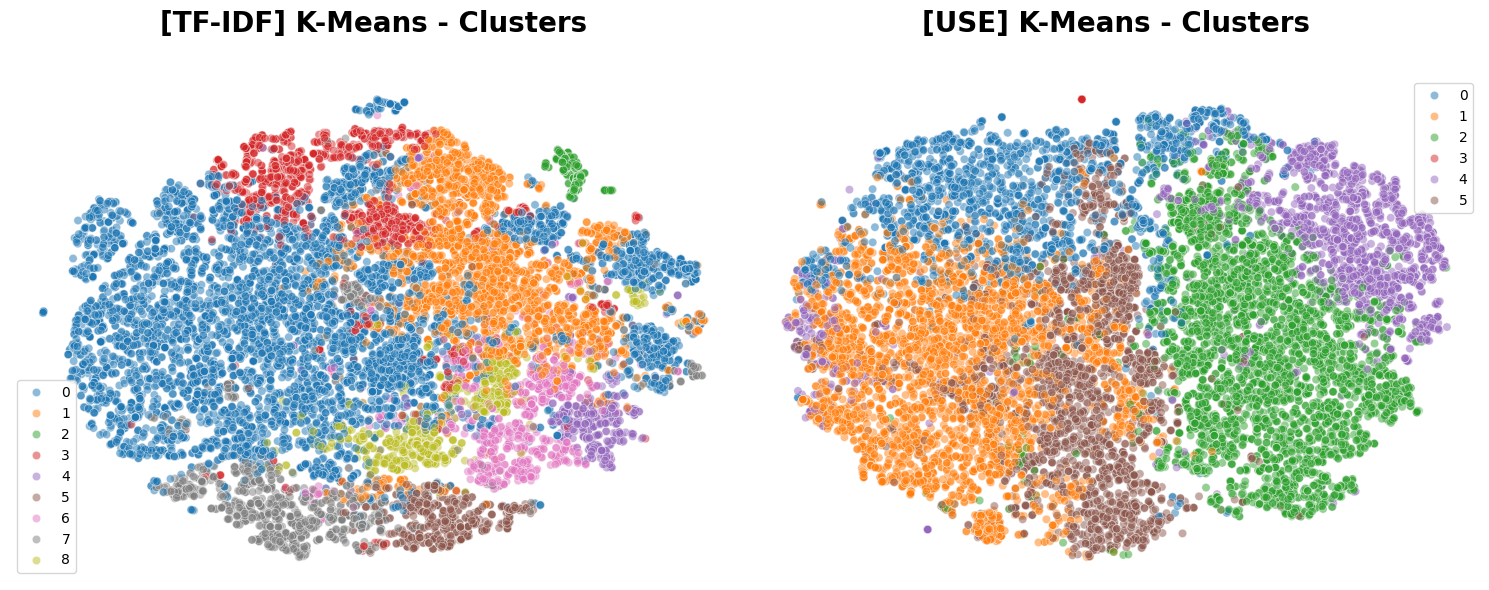

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))

sns.scatterplot(x = trial0[:, 0], y = trial0[:, 1], hue = trial1, palette = 'tab10', alpha = 0.5, ax = axs[0])
axs[0].set_title('[TF-IDF] K-Means - Clusters', fontweight = 'bold', fontsize = 20, pad = 32)
axs[0].legend()
axs[0].axis('off')

sns.scatterplot(x = trial2[:, 0], y = trial2[:, 1], hue = trial3, palette = 'tab10', alpha = 0.5, ax = axs[1])
axs[1].set_title('[USE] K-Means - Clusters', fontweight = 'bold', fontsize = 20, pad = 32)
axs[1].legend()
axs[1].axis('off')

plt.tight_layout()

plt.show()

As anticipated, the performance of the two vectorization methods significantly differs:

  - **TF-IDF**: This method does not effectively capture clear distinctions in the themes of the answers, even though they all pertain to the general topic of medicine

  - **Universal Sentence Encoder** (USE): This approach provides a more plausible distinction between different themes. However, without domain-specific knowledge or labeled data, verifying the presence of distinct sub-themes remains challenging

What if we use the DBSCAN Clustering approach?

In [ ]:
epsilon = 0.9
minPoints = 20

dbscanTFIDF = DBSCAN(eps = epsilon, min_samples = minPoints)
labelTFIDFdbscan = dbscanTFIDF.fit_predict(yTFIDF)

dbscanUSE = DBSCAN(eps = epsilon, min_samples = minPoints)
labelUSEdbscan = dbscanUSE.fit_predict(yUSE)

In [ ]:
unique_labels, counts = np.unique(labelTFIDFdbscan, return_counts = True)

print("****************************** [DBSCAN - TF-IDF] ******************************\n\n")

for label, count in zip(unique_labels, counts):

    print(f"Cluster {label}: {count} elements")

****************************** [DBSCAN - TF-IDF] ******************************


Cluster -1: 33276 elements
Cluster 0: 408 elements
Cluster 1: 26 elements
Cluster 2: 21 elements
Cluster 3: 44 elements
Cluster 4: 59 elements
Cluster 5: 101 elements
Cluster 6: 20 elements


In [ ]:
unique_labels, counts = np.unique(labelUSEdbscan, return_counts = True)

print("****************************** [DBSCAN - USE] ******************************\n\n")

for label, count in zip(unique_labels, counts):

    print(f"Cluster {label}: {count} elements")

****************************** [DBSCAN - USE] ******************************


Cluster -1: 7319 elements
Cluster 0: 26234 elements
Cluster 1: 402 elements


In [ ]:
#skip this section to plot all the points (recall to change the variable names below!)
trial0 = embedTFIDF
trial1 = labelTFIDFdbscan

trial2 = embedUSE
trial3 = labelUSEdbscan

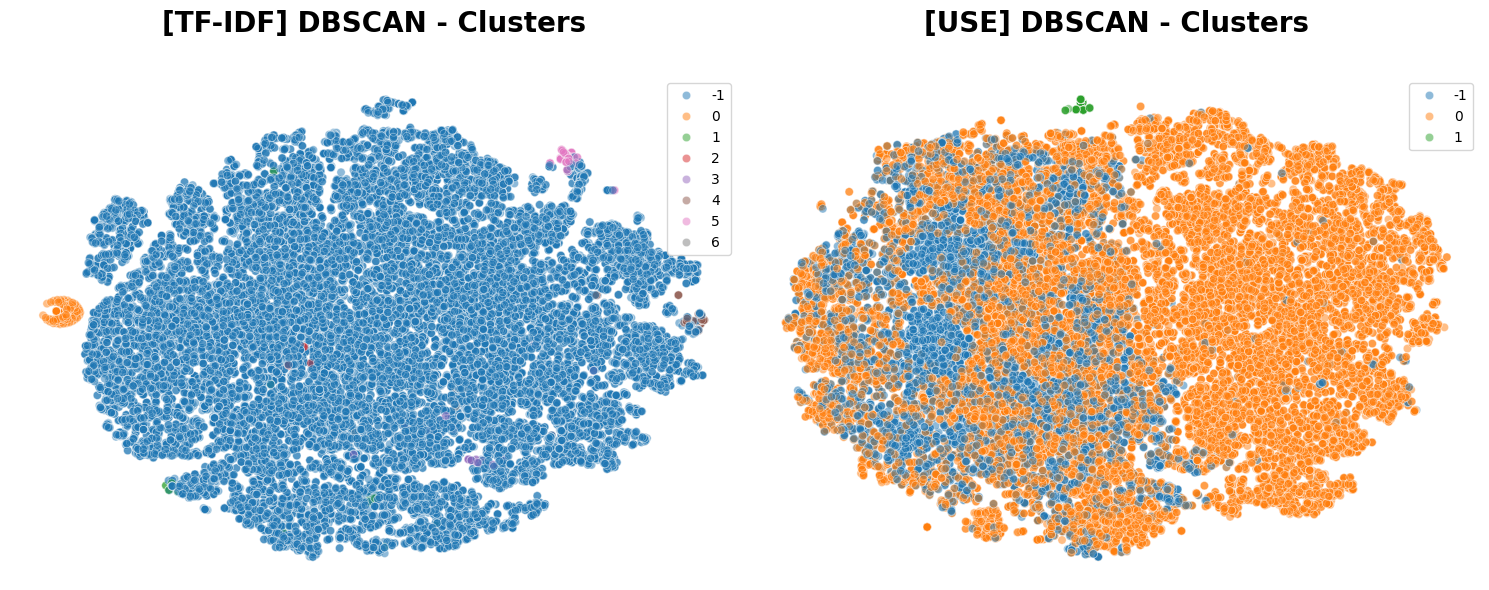

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x = trial0[:, 0], y = trial0[:, 1], hue = trial1, palette = 'tab10', alpha = 0.5, ax = axs[0])
axs[0].set_title('[TF-IDF] DBSCAN - Clusters', fontweight = 'bold', fontsize = 20, pad = 32)
axs[0].legend()
axs[0].axis('off')

sns.scatterplot(x = trial2[:, 0], y = trial2[:, 1], hue = trial3, palette = 'tab10', alpha = 0.5, ax = axs[1])
axs[1].set_title('[USE] DBSCAN - Clusters', fontweight = 'bold', fontsize = 20, pad = 32)
axs[1].legend()
axs[1].axis('off')

plt.tight_layout()

plt.show()

The results from the DBSCAN clustering algorithm highlight some limitations of the TF-IDF model, in particular,  its high dimensionality (10,746 dimensions compared to 512 in USE)* and the sparse nature of the vectors tends to position sentences far apart from each other, which in turn affects the clustering process; consequently, DBSCAN often categorizes a substantial number of data points as noise.

On the other hand, using the Universal Sentence Encoder (USE) does improve the situation by providing a more compact representation of the vectors but the issue is still present: this dimensionality, although reduced, might still not be optimal for DBSCAN. Therefore, exploring alternative algorithms or models that handle high-dimensional data more effectively could be beneficial.


**Although we reduce these dimensions to create 2D plots for visualization, it’s crucial to consider their original scales.*

### Retrieval System

In this section, we experiment with different techniques that can be used to retrieve the answers given a certain query of the user. First we index the questions using PyTerrier, this permit us to retrieve the answer to the question that is most similar to the user query.

In [ ]:
questions = dataset['train']['input']
answers = dataset['train']['output']

df = pd.DataFrame(
    [[f"d{i}", question, answer] for i, (question, answer) in enumerate(zip(questions, answers)) if len(question) > 0],
    columns=["docno", "question", "answer"]
)
df.head()

docno                                           question  \
0    d0  What is the relationship between very low Mg2+...   
1    d1  What leads to genitourinary syndrome of menopa...   
2    d2  What does low REM sleep latency and experienci...   
3    d3  What are some possible causes of low PTH and h...   
4    d4  How does the level of anti-müllerian hormone r...   

                                              answer  
0  Very low Mg2+ levels correspond to low PTH lev...  
1  Low estradiol production leads to genitourinar...  
2  Low REM sleep latency and experiencing halluci...  
3  PTH-independent hypercalcemia, which can be ca...  
4  The level of anti-müllerian hormone is directl...

We use TF-IDF, BM25 and PL2 as weighting functions to index the documents. Here we show the results of a very simple query, where the three methods perform very similar, indeed they retrieve in the first place the same question.

In [ ]:
# Indexing the questions to retrieve the answer to the most similar question
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(df["question"], df["docno"])
index = pt.IndexFactory.of(index_ref)

query = "how to reduce the glucose level"

tf_idf_results = pt.BatchRetrieve(index, wmodel="TF_IDF").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_tf_idf', 'score': 'score_tf_idf'})
bm25_results = pt.BatchRetrieve(index, wmodel="BM25").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_bm25', 'score': 'score_bm25'})
pl2_results = pt.BatchRetrieve(index, wmodel="PL2").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_pl2', 'score': 'score_pl2'})

df.merge(tf_idf_results, on='docno', how='left').merge(bm25_results, on='docno', how='left').merge(pl2_results, on='docno', how='left').sort_values(by='rank_tf_idf')

docno                                           question  \
24008  d24263  How does insulin reduce blood glucose levels a...   
25047  d25303  At what plasma glucose level are all glucose t...   
19418  d19431  What is the test used to detect reducing sugar...   
10614  d10617  What is the composition of reduced glutathione...   
29238  d29586  What is the level of CSF glucose in viral meni...   
...       ...                                                ...   
33542  d33946  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33543  d33947  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33544  d33948             Is A part of B in a proportion of A/B?   
33545  d33949  What is the mnemonic "Microtubules Get Constru...   
33546  d33950  At what age does bed wetting (enuresis) become...   

                                                  answer  rank_tf_idf  \
24008  Insulin reduces blood glucose levels by promot...          0.0   
25047  Glucose transporters are proteins that are res...          1.0   
19418  The copper reduction test is used to detect re...          2.0   
10614  Reduced glutathione is composed of two molecul...          3.0   
29238  The level of CSF glucose in viral meningitis i...          4.0   
...                                                  ...          ...   
33542  Opsoclonus-Myoclonus Ataxia Syndrome is a para...          NaN   
33543  Opsoclonus-Myoclonus Ataxia Syndrome is a para...          NaN   
33544        Yes, A is part of B in a proportion of A/B.          NaN   
33545  The mnemonic "Microtubules Get Constructed Ver...          NaN   
33546  At the age of 5 or older, bed wetting (enuresi...          NaN   

       score_tf_idf  rank_bm25  score_bm25  rank_pl2  score_pl2  
24008     11.038630        0.0   20.120783       0.0   9.843199  
25047      8.391106        1.0   15.276733       1.0   7.661079  
19418      8.282847        2.0   15.149974       3.0   7.406633  
10614      8.280046        3.0   15.063302       2.0   7.564708  
29238      8.109860        4.0   14.749407       4.0   7.341802  
...             ...        ...         ...       ...        ...  
33542           NaN        NaN         NaN       NaN        NaN  
33543           NaN        NaN         NaN       NaN        NaN  
33544           NaN        NaN         NaN       NaN        NaN  
33545           NaN        NaN         NaN       NaN        NaN  
33546           NaN        NaN         NaN       NaN        NaN  

[33547 rows x 9 columns]

Now, we index the answers instead. We do this in order to retrieve the answer that is most similar to the user query.

In [ ]:
# indexing the answers to retrieve the answer most similar to a question
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(df["answer"], df["docno"])
index = pt.IndexFactory.of(index_ref)

query = "how to reduce the glucose level"

tf_idf_results = pt.BatchRetrieve(index, wmodel="TF_IDF").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_tf_idf', 'score': 'score_tf_idf'})
bm25_results = pt.BatchRetrieve(index, wmodel="BM25").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_bm25', 'score': 'score_bm25'})
pl2_results = pt.BatchRetrieve(index, wmodel="PL2").search(query)[['docno', 'rank', 'score']].rename(columns={'rank': 'rank_pl2', 'score': 'score_pl2'})

df.merge(tf_idf_results, on='docno', how='left').merge(bm25_results, on='docno', how='left').merge(pl2_results, on='docno', how='left').sort_values(by='rank_tf_idf')

09:49:39.420 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (d7717) - further warnings are suppressed
09:49:56.121 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 4 empty documents


docno                                           question  \
23762  d24017   Does insulin induce the activity of glucokinase?   
24008  d24263  How does insulin reduce blood glucose levels a...   
10086  d10087  For a diabetic patient taking metformin and ni...   
9331    d9332  What is the recommended target for fasting blo...   
26377  d26635  What does it suggest when someone has high A1c...   
...       ...                                                ...   
33542  d33946  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33543  d33947  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33544  d33948             Is A part of B in a proportion of A/B?   
33545  d33949  What is the mnemonic "Microtubules Get Constru...   
33546  d33950  At what age does bed wetting (enuresis) become...   

                                                  answer  rank_tf_idf  \
23762  Yes, insulin induces the activity of glucokina...          0.0   
24008  Insulin reduces blood glucose levels by promot...          1.0   
10086  The recommended next step in management for a ...          2.0   
9331   The recommended target for fasting blood gluco...          3.0   
26377  High A1c, high random glucose, and high fastin...          4.0   
...                                                  ...          ...   
33542  Opsoclonus-Myoclonus Ataxia Syndrome is a para...          NaN   
33543  Opsoclonus-Myoclonus Ataxia Syndrome is a para...          NaN   
33544        Yes, A is part of B in a proportion of A/B.          NaN   
33545  The mnemonic "Microtubules Get Constructed Ver...          NaN   
33546  At the age of 5 or older, bed wetting (enuresi...          NaN   

       score_tf_idf  rank_bm25  score_bm25  rank_pl2  score_pl2  
23762     10.506909        0.0   18.767500       0.0   9.040035  
24008     10.419992        1.0   18.641184       1.0   9.006875  
10086      9.830929        2.0   17.547767       3.0   8.372971  
9331       9.456197        3.0   16.835647       5.0   7.858816  
26377      9.267705        4.0   16.592211       2.0   8.406234  
...             ...        ...         ...       ...        ...  
33542           NaN        NaN         NaN       NaN        NaN  
33543           NaN        NaN         NaN       NaN        NaN  
33544           NaN        NaN         NaN       NaN        NaN  
33545           NaN        NaN         NaN       NaN        NaN  
33546           NaN        NaN         NaN       NaN        NaN  

[33547 rows x 9 columns]

We test this retrieval system by using as queries the questions in the dataset and we calculate the exact match between the result of the query in the first place and the true answer of the dataset.

In [ ]:
# using as query the questions on the indexed answers to see if the correct answer is retrieved
queries = df['question'].to_frame().reset_index().rename(columns={'index': 'qid', 'question': 'query'})
queries['query'] = queries['query'].apply(lambda q: q.translate(str.maketrans('', '', string.punctuation)))
queries = queries[queries['query'].apply(lambda q: len(q)) > 0]

bm25 = pt.BatchRetrieve(index, wmodel="BM25", blocks=True)(queries)[['qid', 'docno', 'rank', 'score']]
bm25 = bm25.rename(columns={'rank': 'bm25_rank', 'score': 'bm25_score'})
bm25['qid'] = bm25['qid'].astype(int)

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF", blocks=True)(queries)[['qid', 'docno', 'rank', 'score']]
tfidf = tfidf.rename(columns={'rank': 'tfidf_rank', 'score': 'tfidf_score'})
tfidf['qid'] = tfidf['qid'].astype(int)

pl2 = pt.BatchRetrieve(index, wmodel="PL2", blocks=True)(queries)[['qid', 'docno', 'rank', 'score']]
pl2 = pl2.rename(columns={'rank': 'pl2_rank', 'score': 'pl2_score'})
pl2['qid'] = pl2['qid'].astype(int)

results_df = df.reset_index().merge(bm25, left_on=['index', 'docno'], right_on=['qid', 'docno'], how='left').drop(columns=['qid'])
results_df = results_df.merge(tfidf, left_on=['index', 'docno'], right_on=['qid', 'docno'], how='left').drop(columns=['qid'])
results_df = results_df.merge(pl2, left_on=['index', 'docno'], right_on=['qid', 'docno'], how='left').drop(columns=['qid'])
results_df = results_df.drop(columns=['index'])
results_df

BR(BM25):   0%|          | 0/33547 [00:00<?, ?q/s]

BR(TF_IDF):   0%|          | 0/33547 [00:00<?, ?q/s]

BR(PL2):   0%|          | 0/33547 [00:00<?, ?q/s]

docno                                           question  \
0          d0  What is the relationship between very low Mg2+...   
1          d1  What leads to genitourinary syndrome of menopa...   
2          d2  What does low REM sleep latency and experienci...   
3          d3  What are some possible causes of low PTH and h...   
4          d4  How does the level of anti-müllerian hormone r...   
...       ...                                                ...   
33542  d33946  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33543  d33947  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33544  d33948             Is A part of B in a proportion of A/B?   
33545  d33949  What is the mnemonic "Microtubules Get Constru...   
33546  d33950  At what age does bed wetting (enuresis) become...   

                                                  answer  bm25_rank  \
0      Very low Mg2+ levels correspond to low PTH lev...        0.0   
1      Low estradiol production leads to genitourinar...        0.0   
2      Low REM sleep latency and experiencing halluci...        0.0   
3      PTH-independent hypercalcemia, which can be ca...      263.0   
4      The level of anti-müllerian hormone is directl...        0.0   
...                                                  ...        ...   
33542  Opsoclonus-Myoclonus Ataxia Syndrome is a para...        0.0   
33543  Opsoclonus-Myoclonus Ataxia Syndrome is a para...        0.0   
33544        Yes, A is part of B in a proportion of A/B.        0.0   
33545  The mnemonic "Microtubules Get Constructed Ver...        0.0   
33546  At the age of 5 or older, bed wetting (enuresi...        0.0   

       bm25_score  tfidf_rank  tfidf_score  pl2_rank  pl2_score  
0       22.395635         0.0    11.835005       0.0  11.167374  
1       60.837910         0.0    33.798181       0.0  30.168154  
2       73.888701         0.0    40.536192       0.0  36.622319  
3       13.140036       243.0     7.814807     264.0   6.466900  
4       39.921599         0.0    22.091928       0.0  19.739553  
...           ...         ...          ...       ...        ...  
33542   31.524782         0.0    17.658535       0.0  15.044945  
33543   27.616651         0.0    15.449343       0.0  13.592267  
33544   22.050443         0.0    12.116708       0.0  12.220214  
33545   68.901639         0.0    37.949444       0.0  33.442051  
33546   57.083094         0.0    31.283477       0.0  28.061957  

[33547 rows x 9 columns]

In [ ]:
# exact match metric for all the weighting functions
em_tf_idf = results_df[results_df['tfidf_rank'] == 0].shape[0] / results_df.shape[0]
em_bm25 = results_df[results_df['bm25_rank'] == 0].shape[0] / results_df.shape[0]
em_pl2 = results_df[results_df['pl2_rank'] == 0].shape[0] / results_df.shape[0]

print(f'Exact Match TF-IDF: {em_tf_idf}')
print(f'Exact Match BM25: {em_bm25}')
print(f'Exact Match PL2: {em_pl2}')

Exact Match TF-IDF: 0.757564014665991
Exact Match BM25: 0.7545831221867827
Exact Match PL2: 0.7453423555012371


The same procedure is repeated using a Sentence Transformer, in this case the retrieved answer is the one with the highest cosine similarity with the query. Also in this case we evaluate the procedure using the exact match

In [ ]:
# using a sentence transformer to do the same thing, but with the embeddings
model = SentenceTransformer('all-mpnet-base-v2')

questions = df['question'].tolist()
answers = df['answer'].tolist()

batch_size = 64
questions_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=df.shape[0] // batch_size) as pbar:
    while start_batch_idx < df.shape[0]:
        end_batch_idx = start_batch_idx + batch_size
        embeddings_batch = model.encode(questions[start_batch_idx:end_batch_idx], convert_to_tensor=True)
        questions_embeddings = np.concatenate([questions_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
        start_batch_idx = end_batch_idx
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(1)

batch_size = 64
answers_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=df.shape[0] // batch_size) as pbar:
    while start_batch_idx < df.shape[0]:
        end_batch_idx = start_batch_idx + batch_size
        embeddings_batch = model.encode(answers[start_batch_idx:end_batch_idx], convert_to_tensor=True)
        answers_embeddings = np.concatenate([answers_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
        start_batch_idx = end_batch_idx
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(1)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

525it [03:49,  2.28it/s]
525it [06:42,  1.30it/s]


In [ ]:
scores = []
ranks = []
for i, question_emb in tqdm.tqdm(enumerate(questions_embeddings), total=df.shape[0]):
    cosine_similarities = question_emb.reshape(1, -1) @ answers_embeddings.T
    cosine_similarities = cosine_similarities.flatten()
    ranked_cosine_similarities = np.argsort(cosine_similarities).argsort()
    # the i-th element is the score of the corresponding answer
    scores.append(cosine_similarities[i])
    ranks.append(ranked_cosine_similarities[i])

# argsort produces ranking in ascending order, this is why len(...) - ranks
df['embeddings_rank'] = len(answers) - np.array(ranks)
df['embeddings_scores'] = scores
em_tr = df[df['embeddings_rank'] == 1].shape[0] / df.shape[0]
print(f'Exact Match Sentence Transformer: {em_tr}')
df

100%|██████████| 33547/33547 [02:50<00:00, 196.84it/s]


Exact Match Sentence Transformer: 0.7671922973738338


docno                                           question  \
0          d0  What is the relationship between very low Mg2+...   
1          d1  What leads to genitourinary syndrome of menopa...   
2          d2  What does low REM sleep latency and experienci...   
3          d3  What are some possible causes of low PTH and h...   
4          d4  How does the level of anti-müllerian hormone r...   
...       ...                                                ...   
33542  d33946  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33543  d33947  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33544  d33948             Is A part of B in a proportion of A/B?   
33545  d33949  What is the mnemonic "Microtubules Get Constru...   
33546  d33950  At what age does bed wetting (enuresis) become...   

                                                  answer  embeddings_rank  \
0      Very low Mg2+ levels correspond to low PTH lev...                1   
1      Low estradiol production leads to genitourinar...                1   
2      Low REM sleep latency and experiencing halluci...                1   
3      PTH-independent hypercalcemia, which can be ca...                3   
4      The level of anti-müllerian hormone is directl...                1   
...                                                  ...              ...   
33542  Opsoclonus-Myoclonus Ataxia Syndrome is a para...                1   
33543  Opsoclonus-Myoclonus Ataxia Syndrome is a para...                1   
33544        Yes, A is part of B in a proportion of A/B.                1   
33545  The mnemonic "Microtubules Get Constructed Ver...                1   
33546  At the age of 5 or older, bed wetting (enuresi...                1   

       embeddings_scores  
0               0.897001  
1               0.874388  
2               0.858203  
3               0.748378  
4               0.884405  
...                  ...  
33542           0.878066  
33543           0.867896  
33544           0.937603  
33545           0.885519  
33546           0.884358  

[33547 rows x 5 columns]

### Fine-Tuning of the Retrieval Model



In this section, we fine-tune the previous retrieval model with the aim of improving the previous exact match metric. Indeed, the performances of the pretrained model were so much better than much simpler models like TF-IDF or BM25. While the pretrained model is trained on a general task, with fine tuning we aim at making it learn a better representation of the input text sequences for this task. We have a set of pairs of questions and answers, which form a set of positive pairs for the Sentence Transformer. Since we only have positive pairs, we train the model using the `MultipleNegativesRankingLoss` loss function

First, we split the data in train and test set in order to be able to evaluate the differences between the fine tuned model and the original one.

In [ ]:
questions = df['question'].tolist()
answers = df['answer'].tolist()
questions_train, questions_val, answers_train, answers_val = train_test_split(questions, answers, test_size=0.5, shuffle=True, random_state=42)

In [ ]:
model_id = 'all-mpnet-base-v2'
model = SentenceTransformer(model_id)

We evaluate the original model on the validation split in order to have a fair comparison with the fine-tuned model

In [ ]:
batch_size = 512
questions_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=len(questions_val) // batch_size) as pbar:
    while start_batch_idx < len(questions_val):
        end_batch_idx = start_batch_idx + batch_size
        if start_batch_idx < len(questions_val):
            embeddings_batch = model.encode(questions_val[start_batch_idx:end_batch_idx], convert_to_tensor=True)
            questions_embeddings = np.concatenate([questions_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
            gc.collect()
            torch.cuda.empty_cache()
            pbar.update(1)
        start_batch_idx = end_batch_idx

answers_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=len(answers_val) // batch_size) as pbar:
    while start_batch_idx < len(answers_val):
        end_batch_idx = start_batch_idx + batch_size
        if start_batch_idx < len(answers_val):
            embeddings_batch = model.encode(answers_val[start_batch_idx:end_batch_idx], convert_to_tensor=True)
            answers_embeddings = np.concatenate([answers_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
            gc.collect()
            torch.cuda.empty_cache()
            pbar.update(1)
        start_batch_idx = end_batch_idx

scores = []
ranks = []
for i, question_emb in tqdm.tqdm(enumerate(questions_embeddings), total=questions_embeddings.shape[0]):
    cosine_similarities = question_emb.reshape(1, -1) @ answers_embeddings.T
    cosine_similarities = cosine_similarities.flatten()
    ranked_cosine_similarities = np.argsort(cosine_similarities).argsort()
    scores.append(cosine_similarities[i])
    ranks.append(ranked_cosine_similarities[i])

em_tr = np.sum(len(answers_val) - np.array(ranks) == 1) / len(answers_val)
print(f'\nExact Match Before Fine Tuning Sentence Transformer: {em_tr}')

33it [00:13,  2.40it/s]
33it [00:27,  1.18it/s]
100%|██████████| 16774/16774 [00:34<00:00, 490.41it/s]


Exact Match Before Fine Tuning Sentence Transformer: 0.8367711935137713


In [ ]:
from sentence_transformers import InputExample
from torch.utils.data import DataLoader

train_data = []
for question, answer in zip(questions_train, answers_train):
    train_data.append(InputExample(texts=[question, answer]))
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=64)

val_data = []
for question, answer in zip(questions_val, answers_val):
    val_data.append(InputExample(texts=[question, answer]))
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=64)

In [ ]:
from sentence_transformers.losses import MultipleNegativesRankingLoss

loss = MultipleNegativesRankingLoss(model=model)
model.fit(train_objectives=[(train_dataloader, loss)], epochs=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

Iteration:   0%|          | 0/263 [00:00<?, ?it/s]

In [ ]:
batch_size = 512
questions_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=len(questions_val) // batch_size) as pbar:
    while start_batch_idx < len(questions_val):
        end_batch_idx = start_batch_idx + batch_size
        if start_batch_idx < len(questions_val):
            embeddings_batch = model.encode(questions_val[start_batch_idx:end_batch_idx], convert_to_tensor=True)
            questions_embeddings = np.concatenate([questions_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
            gc.collect()
            torch.cuda.empty_cache()
            pbar.update(1)
        start_batch_idx = end_batch_idx

answers_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm.tqdm(total=len(answers_val) // batch_size) as pbar:
    while start_batch_idx < len(answers_val):
        end_batch_idx = start_batch_idx + batch_size
        if start_batch_idx < len(answers_val):
            embeddings_batch = model.encode(answers_val[start_batch_idx:end_batch_idx], convert_to_tensor=True)
            answers_embeddings = np.concatenate([answers_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
            gc.collect()
            torch.cuda.empty_cache()
            pbar.update(1)
        start_batch_idx = end_batch_idx

scores = []
ranks = []
for i, question_emb in tqdm.tqdm(enumerate(questions_embeddings), total=questions_embeddings.shape[0]):
    cosine_similarities = question_emb.reshape(1, -1) @ answers_embeddings.T
    cosine_similarities = cosine_similarities.flatten()
    ranked_cosine_similarities = np.argsort(cosine_similarities).argsort()
    scores.append(cosine_similarities[i])
    ranks.append(ranked_cosine_similarities[i])

em_tr = np.sum(len(answers_val) - np.array(ranks) == 1) / len(answers_val)
print(f'\nExact Match After Fine Tuning Sentence Transformer: {em_tr}')

33it [00:14,  2.28it/s]
33it [00:28,  1.16it/s]
100%|██████████| 16774/16774 [00:34<00:00, 483.41it/s]


Exact Match After Fine Tuning Sentence Transformer: 0.9283414808632408


We push the model to hugging face in order to be able to utilize it in a second moment

In [ ]:
model_name = "mpnet_model"
output_dir = f"{model_name}"

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

api = HfApi()
username = api.whoami()['name']
repo_url = api.create_repo(repo_id=f"{username}/{model_name}", exist_ok=True)
repo = Repository(local_dir=output_dir, clone_from=repo_url)

model.save(output_dir)

repo.push_to_hub(commit_message="Initial commit")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/CarloSgara/mpnet_model into local empty directory.


Upload file model.safetensors:   0%|          | 1.00/418M [00:00<?, ?B/s]

To https://huggingface.co/CarloSgara/mpnet_model
   1a21cd4..0c1fe4a  main -> main

   1a21cd4..0c1fe4a  main -> main



'https://huggingface.co/CarloSgara/mpnet_model/commit/0c1fe4a95e51fd381085d297e34db1fbc705970e'

### Generative Models

To speed up the execution during the presentation, we will import the necessary libraries required for the demo here.

#### Import Libraries

In [ ]:
!pip3 install datasets
!pip install transformers
!pip install accelerate -U
!pip install gradio
!pip install -U sentence-transformers
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install -i https://pypi.org/simple/ bitsandbytes
!pip install xformers
!pip install peft
! pip install trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_6

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, pipeline
from transformers import StoppingCriteria, StoppingCriteriaList
from datasets import load_dataset, DatasetDict, Dataset
from datetime import datetime
from huggingface_hub import login
import gradio as gr
from sentence_transformers import SentenceTransformer, util
from unsloth import FastLanguageModel
import numpy as np
from tqdm import tqdm
import gc
import random

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


#### Minerva

In this section we fine-tune the first italian LLM, called Minerva, developed by by the Sapienza NLP Team in collaboration with Future Artificial Intelligence Research (FAIR) and CINECA; specifically, we used the version with 350 million parameters due to computational limits, though versions with 1 billion and 3 billion parameters also exist.

Although the technical report for this model is not yet available, we know from the corresponding [Hugging Face Repository](https://huggingface.co/sapienzanlp/Minerva-3B-base-v1.0) that the version used consists of 16 layers with 16 attention heads, and it can process a context with a maximum length of 16,384 tokens.  
The fine-tuned version of this model and the corresponding documentation is available [here](https://huggingface.co/FabioS08/MedicalFlashcardsMinerva).

In [ ]:
# Minerva has public access but requires the user to be authenticated

login()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sapienzanlp/Minerva-350M-base-v1.0")
model = AutoModelForCausalLM.from_pretrained("sapienzanlp/Minerva-350M-base-v1.0", device_map = "cuda")


tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Generate the Train-Validation-Test split
trainTestSplit = dataset['train'].train_test_split(test_size = 0.2, seed = 42)
tempSplit = trainTestSplit['test'].train_test_split(test_size = 0.3, seed = 42)

# Combine splits into a DatasetDict
datasetSplits = DatasetDict({

    'train': trainTestSplit['train'],
    'validation': tempSplit['train'],
    'test': tempSplit['test'],
})

print(datasetSplits)

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 27164
    })
    validation: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 4753
    })
    test: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 2038
    })
})


In [ ]:
def preprocessFunction(examples):

    inputs = examples['input']
    outputs = examples['output']

    concatenated = [tokenizer.bos_token + " " + input_text + " " + tokenizer.eos_token + " " + tokenizer.bos_token + " " + output_text + " " +
                    tokenizer.eos_token for input_text, output_text in zip(inputs, outputs)]

    return tokenizer(concatenated, truncation = True)


tokenizedDatasets = datasetSplits.map(preprocessFunction, batched = True)
tokenizedDatasets = tokenizedDatasets.remove_columns(['instruction'])

In [ ]:
tokenizedDatasets

In [ ]:
dataCollator = DataCollatorForLanguageModeling(tokenizer, mlm = False)


trainingArgs = TrainingArguments(

    output_dir = "MedicalFlashcardsMinerva",
    evaluation_strategy = "steps",
    save_strategy = "steps",
    learning_rate = 2e-4,
    per_device_train_batch_size = 6,
    per_device_eval_batch_size = 6,
    gradient_accumulation_steps = 8,
    num_train_epochs = 3,
    lr_scheduler_type = "cosine",
    warmup_ratio = 0.1,
    adam_beta1 = 0.9,
    adam_beta2 = 0.95,
    adam_epsilon = 1e-8,
    weight_decay = 0.01,
    logging_steps = 200,
    report_to = "none"

    )


trainer = Trainer(

    model = model,
    args = trainingArgs,
    train_dataset = tokenizedDatasets['train'],
    eval_dataset = tokenizedDatasets['validation'],
    data_collator = dataCollator

    )

In [ ]:
trainer.train()

In [ ]:
checkpointPath = f"Minerva{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"

tokenizer.save_pretrained(checkpointPath)
model.save_pretrained(checkpointPath)

print(f"Checkpoint saved at: \'{checkpointPath}\'")

#### LLAMA 3

[Llama3](https://llama.meta.com/llama3/) is a LLM created by Meta in 2024. Thanks to the [Unsloth framework](https://github.com/unslothai/unsloth), which allow very efficient training using less memory, we were able to finetune the smallest version of the model containing 8 billions parameters. All the arguments for the training were already defined from unsloth in order to get the best performance.

In [ ]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

# loading the model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

In [ ]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# transforming the dataset in the required format
EOS_TOKEN = tokenizer.eos_token
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass


dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
# Split the dataset into train and temp (for further splitting into validation and test)
train_test_split = dataset['train'].train_test_split(test_size = 0.2, seed = 42)
temp_split = train_test_split['test'].train_test_split(test_size = 0.3, seed = 42)

# Combine splits into a DatasetDict
dataset_splits = DatasetDict({
    'train': train_test_split['train'],
    'validation': temp_split['train'],
    'test': temp_split['test'],
})
dataset_splits = dataset_splits.map(formatting_prompts_func, batched = True,)
dataset_splits

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_splits['train'],
    eval_dataset = dataset_splits['validation'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 250,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy='steps',
        eval_steps=100,
    ),
)
trainer_stats = trainer.train()

Here is the plot of the loss during the training phase:

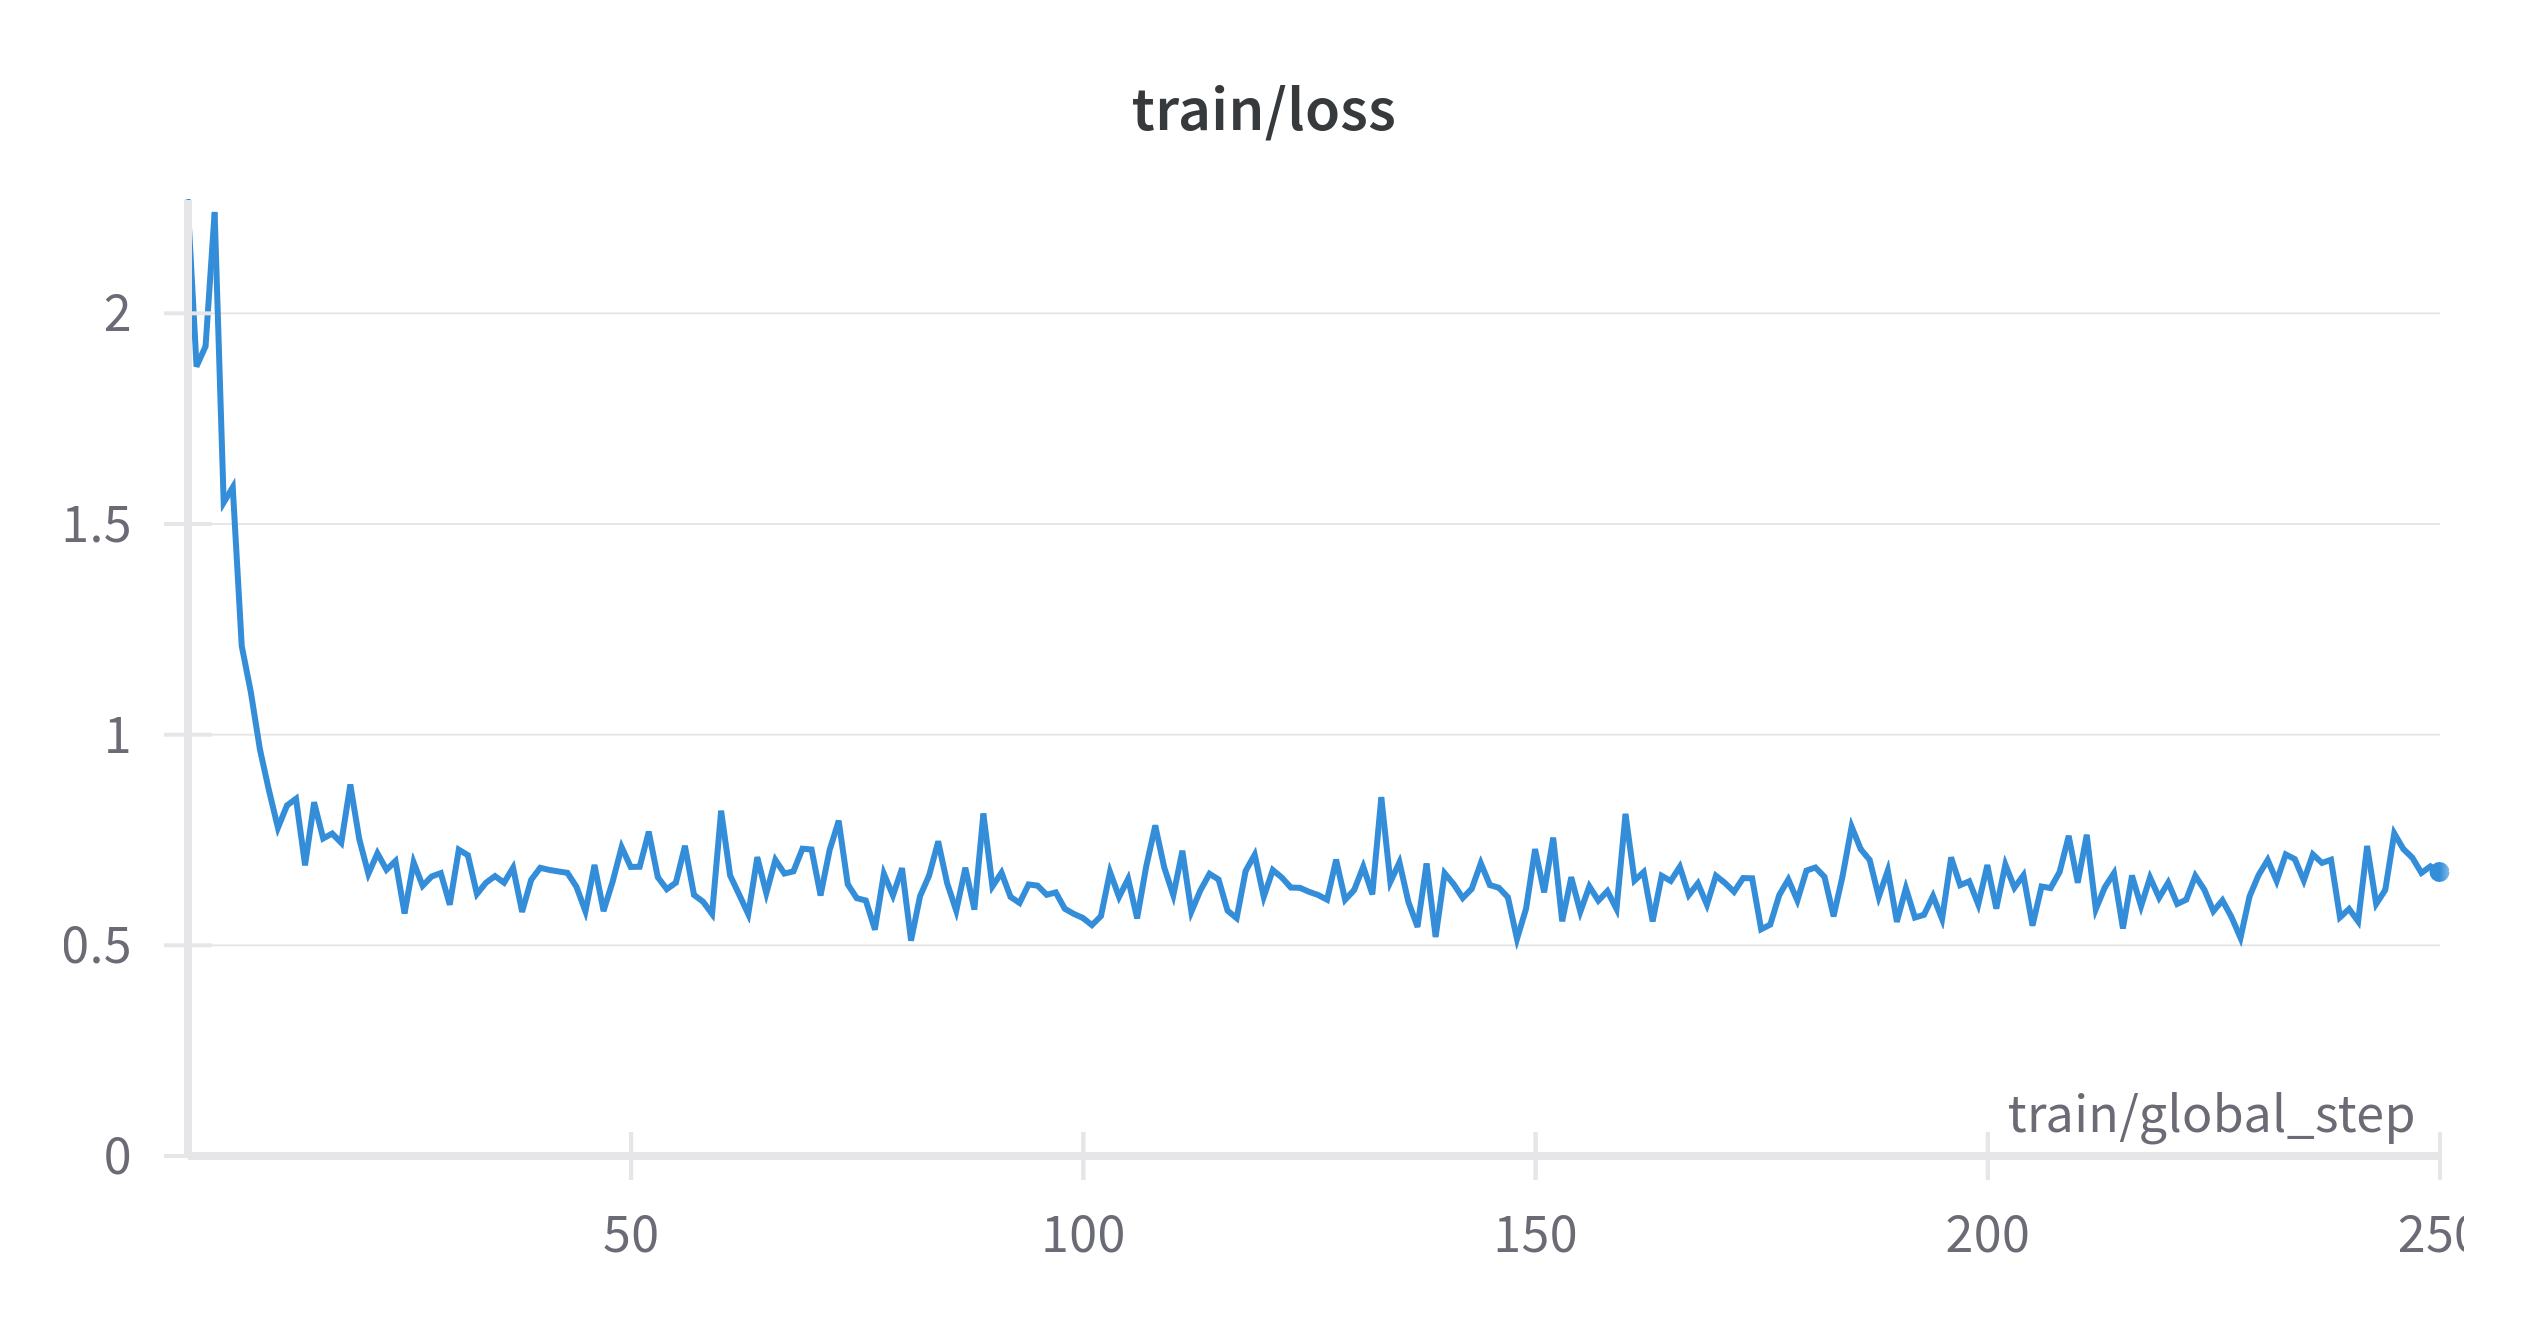

### Tri-Bot: Three Models, Three Answers

In this section, we have developed a simple graphical interface that takes a question as input and returns answers generated by three models: Minerva, LLAMA3, and MPNET (which functions as a retrieval system based on semantic search).

In [ ]:
# Load Minerva
tokenizer_minerva = AutoTokenizer.from_pretrained("FabioS08/MedicalFlashcardsMinerva")
model_minerva = AutoModelForCausalLM.from_pretrained("FabioS08/MedicalFlashcardsMinerva", device_map = "cuda")

tokenizer_config.json:   0%|          | 0.00/961 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/795k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.41G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

In [ ]:
max_seq_length = 2048
dtype = None
load_in_4bit = True

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

# loading the finetuned version of the model directly from Huggingface
model_llama3, tokenizer_llama3 = FastLanguageModel.from_pretrained(
  model_name = "LorenzoBozzoni/llama3_finetuned_final",
  max_seq_length = max_seq_length,
  dtype = dtype,
  load_in_4bit = load_in_4bit,
  device_map="cuda"
)
FastLanguageModel.for_inference(model_llama3) # Enable native 2x faster inference

adapter_config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

==((====))==  Unsloth: Fast Llama patching release 2024.5
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

Unsloth 2024.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [ ]:
# Load MPNET
model_mpnet = SentenceTransformer('CarloSgara/mpnet_model')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/164 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
# Since 'Minerva' presents some issues with the generation of the answer (it basically never stops), we overwrite the stopping
# conditions such that it will terminate the generation at the first period (even if this is not the best choice in all the possible scenarios)

class newStoppingCriteria(StoppingCriteria):

    def __init__(self, stop_word):
        self.stop_word = stop_word

    def __call__(self, input_ids, scores, **kwargs):

        decoded_text = tokenizer_minerva.decode(input_ids[0], skip_special_tokens=True)
        return self.stop_word in decoded_text

criteria = newStoppingCriteria(stop_word = ".")
stoppingCriteriaList = StoppingCriteriaList([criteria])


def generationMinervaResponse(question):

  inputEncoding = tokenizer_minerva(question, return_tensors = 'pt').to('cuda')
  output_ids = model_minerva.generate(

      inputEncoding.input_ids,
      max_length = 128,
      do_sample = True,
      temperature = 0.7,
      top_p = 0.97,
      top_k = 2,
      pad_token_id = tokenizer_minerva.eos_token_id,
      repetition_penalty = 1.2,
      stopping_criteria = stoppingCriteriaList
  )


  # The model returns in the answer the question as well, we will remove it before returning the response
  outputText = tokenizer_minerva.decode(output_ids[0], skip_special_tokens = True)
  inputText = tokenizer_minerva.decode(inputEncoding.input_ids[0], skip_special_tokens = True)
  answer = outputText[len(inputText):].strip()

  return answer

In [ ]:
def generationLlamaResponse(question):

  inputs = tokenizer_llama3(
  [
      alpaca_prompt.format(
          "Answer this question truthfully", # instruction
          question, # input
          "", # output - leave this blank for generation!https://llama.meta.com/llama3/
      )
  ], return_tensors = "pt").to("cuda")

  output = model_llama3.generate(**inputs, max_new_tokens = 100, use_cache = True)#64

  decoded_output = tokenizer_llama3.batch_decode(output)[0][225:-16]

  response_marker = "### Response:\n"
  response_start = decoded_output.find(response_marker) + len(response_marker)

  return decoded_output[response_start:].strip()

In [ ]:
# In order to retrieve a response with MPNet, we need to calculate the embeddings of all the answers
answers = dataset['train']['output']

batch_size = 512
answers_embeddings = np.empty(shape=(0, 768) , dtype = np.float32)
start_batch_idx = 0

with tqdm(total=len(answers) // batch_size) as pbar:
    while start_batch_idx < len(answers):
        end_batch_idx = start_batch_idx + batch_size
        if start_batch_idx < len(answers):
            embeddings_batch = model_mpnet.encode(answers[start_batch_idx:end_batch_idx], convert_to_tensor=True)
            answers_embeddings = np.concatenate([answers_embeddings, F.normalize(embeddings_batch, p=2, dim=1).detach().to('cpu').numpy()], axis=0)
            gc.collect()
            torch.cuda.empty_cache()
            pbar.update(1)
        start_batch_idx = end_batch_idx


def retrieve_mpnet_response(question):
    embeddings = model_mpnet.encode([question], convert_to_tensor=True)
    normalized_embedding = F.normalize(embeddings, p=2, dim=1).detach().to('cpu').numpy()
    cosine_similarities = normalized_embedding @ answers_embeddings.T
    answer_id = np.argmax(cosine_similarities.flatten())
    return answers[answer_id]

67it [03:49,  3.43s/it]


In [ ]:
def generate_responses(question):

    response1 = generationMinervaResponse(question)
    response2 = generationLlamaResponse(question)
    response3 = retrieve_mpnet_response(question)

    return response1, response2, response3


with gr.Blocks(theme = 'gradio/monochrome') as demo:

    gr.Markdown("<h2 style='font-size: 36px;'>Tri-Bot<br>Three Models, Three Answers </h2>")
    gr.Markdown("<p>Aks your questions: Minerva, LLAMA3 and MPNET will answer in the best possible way!</p>")

    with gr.Row():
        response1 = gr.Textbox(label = "Minerva", interactive = False, lines = 4, elem_id = "response1")
        response2 = gr.Textbox(label = "LLAMA3", interactive = False, lines = 4, elem_id = "response2")
        response3 = gr.Textbox(label = "MPNET", interactive = False, lines = 4, elem_id = "response3")

    with gr.Row():
        question = gr.Textbox(placeholder = "Ask a question...", label = "")
        submit_btn = gr.Button("Send", elem_id="submit-button")

    submit_btn.click(generate_responses, inputs=question, outputs=[response1, response2, response3])



    demo.css = """

    .gradio-container {
        background: url(https://cdn.hero.page/wallpapers/121fb583-c65c-4988-bd92-06e0e9b0ed2e-minimalist-mountain-peaks-wallpaper-wallpaper-1.png);

    }

    #submit-button button {

        font-size: 15px;

    }

    #response1, #response2, #response3 {

        display: flex;
        align-items: center;
        justify-content: center;
        text-align: center;

    }


    """

demo.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://abc111f2f5016c08f1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
index = random.randint(0, len(datasetSplits['test']) - 1)

question = datasetSplits['test'][index]['input']
answer = datasetSplits['test'][index]['output']

print(f"[QUESTION]: {question}")
print(f"[ANSWER]: {answer}")

[QUESTION]: What is the recommended treatment for a person with both diabetes and microalbuminuria?
[ANSWER]: Diabetes and microalbuminuria = add ACE-I.


Below there is an example of executing our simple graphical interface, where the three models respond to the provided question!

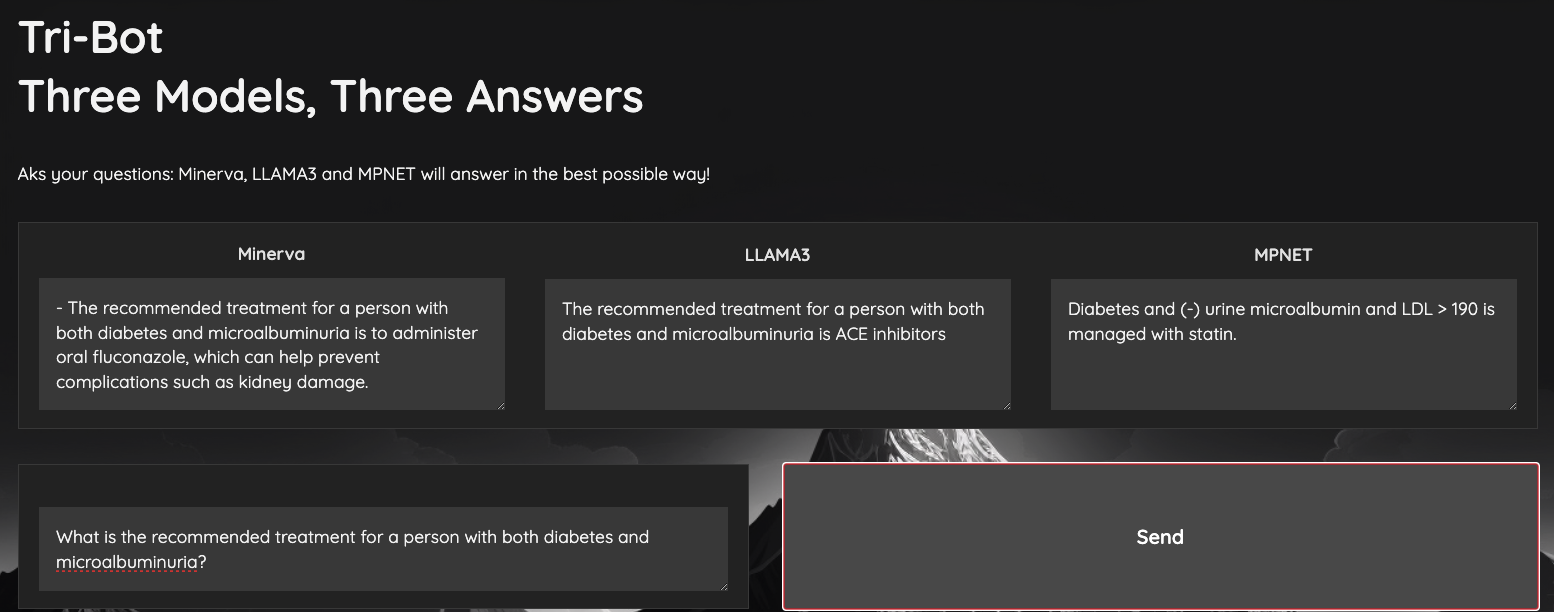